In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import sys
import tracemalloc
import seaborn as sns

In [93]:
def distance(a,b):
    return np.sqrt(np.sum((a - b)**2))                      

In [94]:
def generate_dataset(N, D):
    return np.random.rand(N, D)

def generate_query(D):
    return np.random.rand(D)

# Naive

In [95]:
def naive_knn(query, dataset, K):
    distances = [distance(query, point) for point in dataset]
    sorted_indices = np.argsort(distances)

    k_sorted_points =  np.array([dataset[i] for i in sorted_indices[:K]])
    k_sorted_distances = np.array(distances)[sorted_indices[:K]]

    return sorted_indices[:K], k_sorted_points,  k_sorted_distances

In [96]:
N,D,K= 1000, 5, 10
ds= generate_dataset(N,D)
q= generate_query(D)
if D==2:
    plt.scatter(ds[:, 0], ds[:, 1])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Scatter plot of 2D Dataset')
    plt.show()

In [97]:
indices, points, distances=naive_knn(q, ds, K)
print(points.shape)
print(indices)
print(points)
print(distances)

(10, 5)
[453 756 277 401 666 396  68 162 979 593]
[[0.89388357 0.1755136  0.87103673 0.61746202 0.48658204]
 [0.74644317 0.10501827 0.7965803  0.5188819  0.48013466]
 [0.82183481 0.05799055 0.96523241 0.4941493  0.47304331]
 [0.9580586  0.13567966 0.90690223 0.70342625 0.55689238]
 [0.92786426 0.02468132 0.90910748 0.71027306 0.31769656]
 [0.76139081 0.14030346 0.94264167 0.38368758 0.48142445]
 [0.64427431 0.24802813 0.76809373 0.53680903 0.41976896]
 [0.99455133 0.22660684 0.76307927 0.66273635 0.43432351]
 [0.79576823 0.1835984  0.94426347 0.43152263 0.65947543]
 [0.64107076 0.29225468 0.74577156 0.56249589 0.40145055]]
[0.12390563 0.1378944  0.13971408 0.21480832 0.22613958 0.23364113
 0.26137298 0.26750353 0.28563911 0.29909215]


# KD Tree

In [98]:
class KDTree:
    def __init__(self, data, leaf_size):
        self.data = np.hstack((data, np.arange(len(data)).reshape(-1, 1))) ##stacking the indices
        self.leaf_size = leaf_size
        self.tree = self.build_kdtree(self.data)
    
    def build_kdtree(self, data, depth=0):
        if len(data) <= self.leaf_size:
            return data  
        
        axis = depth % (data.shape[1] - 1)  # Alternate splitting axis, ignore index column
        sorted_data = data[data[:, axis].argsort()]
        median_index = len(sorted_data) // 2
        left = self.build_kdtree(sorted_data[:median_index], depth + 1)
        right = self.build_kdtree(sorted_data[median_index + 1:], depth + 1)
        
        return (sorted_data[median_index], left, right)
    
    def query(self, query, K):
        indices, distances = self._query(self.tree, query, K, depth=0) 
        points = self.data[indices, :-1]
        return indices, points, distances
    
    def _query(self, node, query, K, depth):
    
        if isinstance(node, np.ndarray): #leaf node is an array
            points = node[:, :-1] 
            original_indices = node[:, -1].astype(int)  
            distances = np.array([distance(query, point) for point in points])
            sorted_indices = np.argsort(distances)
            nearest_indices = original_indices[sorted_indices[:K]]
            nearest_distances = distances[sorted_indices[:K]]
            return nearest_indices, nearest_distances
        
        if isinstance(node, tuple) and len(node) == 3: # non-leaf node is a tuple (median point, left subtree, right subtree)
            median, left, right = node
            axis = depth % (query.shape[0])
            
            if query[axis] < median[axis]:
                primary, other = left, right
            else:
                primary, other = right, left
            
            # Recursively search the primary side
            indices, distances = self._query(primary, query, K, depth + 1)
            
            
            if len(indices) < K or abs(query[axis] - median[axis]) < max(distances): # if the other tree's data also need to be combined
                other_indices, other_distances = self._query(other, query, K, depth + 1)
                combined_indices = np.concatenate([indices, other_indices])
                combined_distances = np.concatenate([distances, other_distances])
                sorted_combined = np.argsort(combined_distances)
                indices = combined_indices[sorted_combined][:K]
                distances = combined_distances[sorted_combined][:K]
            
            return indices, distances
        
       
        return np.array([]), np.array([])


In [99]:

tree = KDTree(ds, leaf_size=20) ## training


indices, points, distances = tree.query(q, K) ##testing

print("Indices of nearest neighbors:", indices)
print("Nearest points:", points)
print("Distances to nearest points:", distances)


Indices of nearest neighbors: [453 756 277 401 666 396  68 162 979 593]
Nearest points: [[0.89388357 0.1755136  0.87103673 0.61746202 0.48658204]
 [0.74644317 0.10501827 0.7965803  0.5188819  0.48013466]
 [0.82183481 0.05799055 0.96523241 0.4941493  0.47304331]
 [0.9580586  0.13567966 0.90690223 0.70342625 0.55689238]
 [0.92786426 0.02468132 0.90910748 0.71027306 0.31769656]
 [0.76139081 0.14030346 0.94264167 0.38368758 0.48142445]
 [0.64427431 0.24802813 0.76809373 0.53680903 0.41976896]
 [0.99455133 0.22660684 0.76307927 0.66273635 0.43432351]
 [0.79576823 0.1835984  0.94426347 0.43152263 0.65947543]
 [0.64107076 0.29225468 0.74577156 0.56249589 0.40145055]]
Distances to nearest points: [0.12390563 0.1378944  0.13971408 0.21480832 0.22613958 0.23364113
 0.26137298 0.26750353 0.28563911 0.29909215]


## Testing

### Varying the dataset size and the number of dimensions

In [100]:
dataset_size = [10, 100, 500, 1000, 2000, 3000, 4000, 5000]
dimensions = [5, 10, 20, 50, 100]

In [101]:
#varying the data_set size and the number of dimensions

training_times_KD_tree = np.zeros((len(dataset_size), len(dimensions)))
testing_times_KD_tree = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_KD_tree = np.zeros((len(dataset_size), len(dimensions)))

for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        start_train_time = time.time()
        tree = KDTree(ds, leaf_size=20)
        end_train_time = time.time()
        training_times_KD_tree[i, j] = end_train_time - start_train_time
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_KD_tree[i, j] = peak
         
        tracemalloc.clear_traces()
        
        start_test_time = time.time()
        indices, points, distances = tree.query(q, K)
        end_test_time = time.time()
        testing_times_KD_tree[i, j] = end_test_time - start_test_time

tracemalloc.stop()

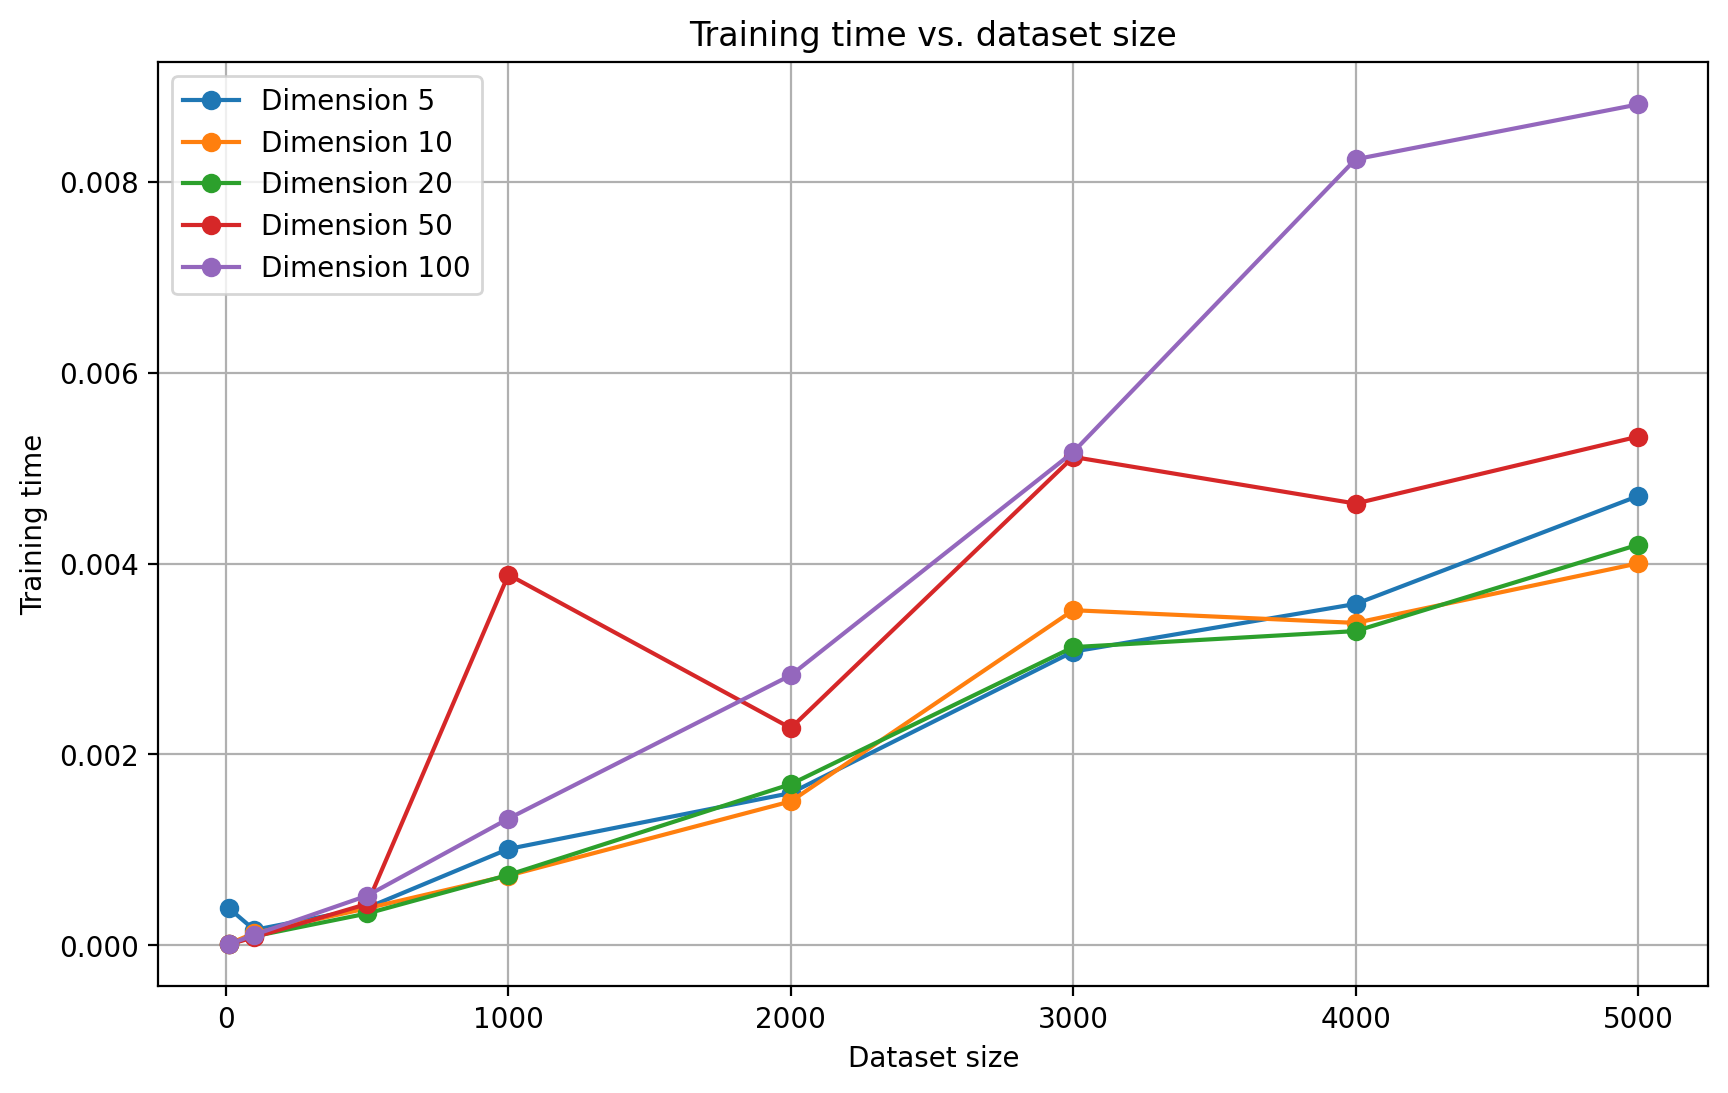

In [102]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, training_times_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Training time')
plt.title('Training time vs. dataset size')
plt.legend()
plt.grid(True)
plt.show()

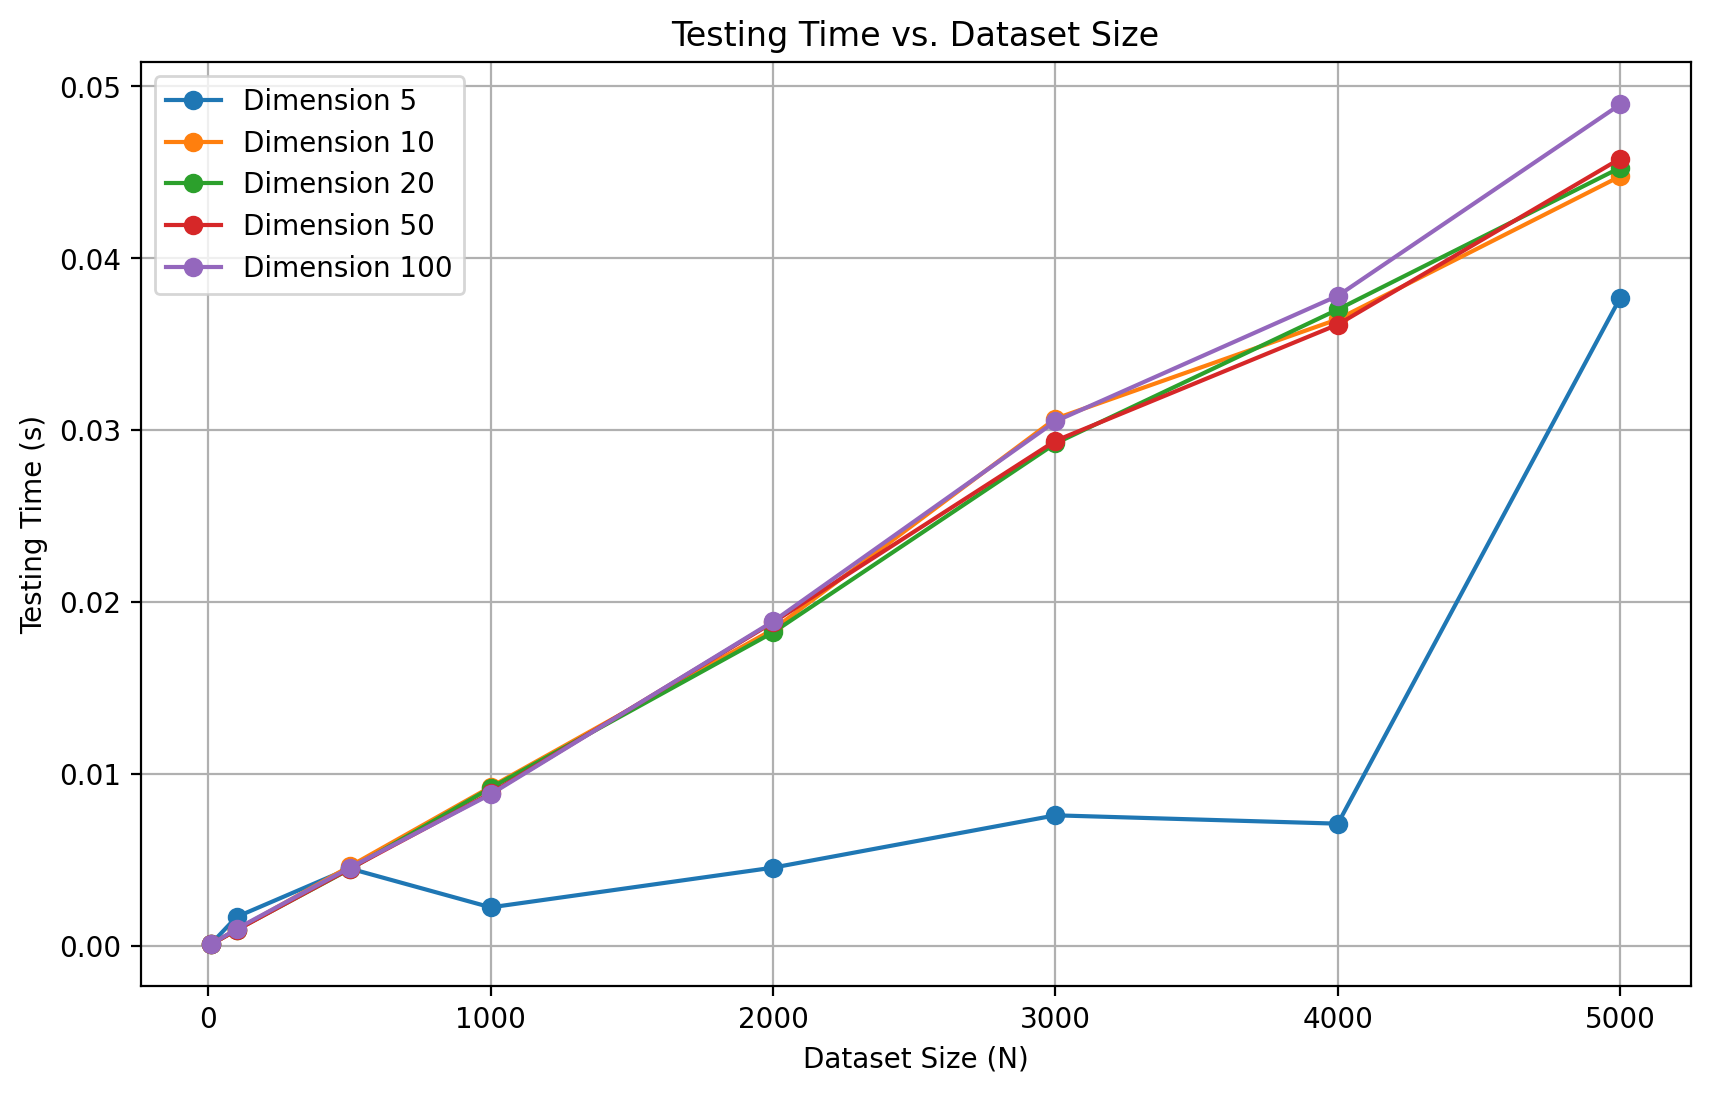

In [103]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Testing Time (s)')
plt.title('Testing Time vs. Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

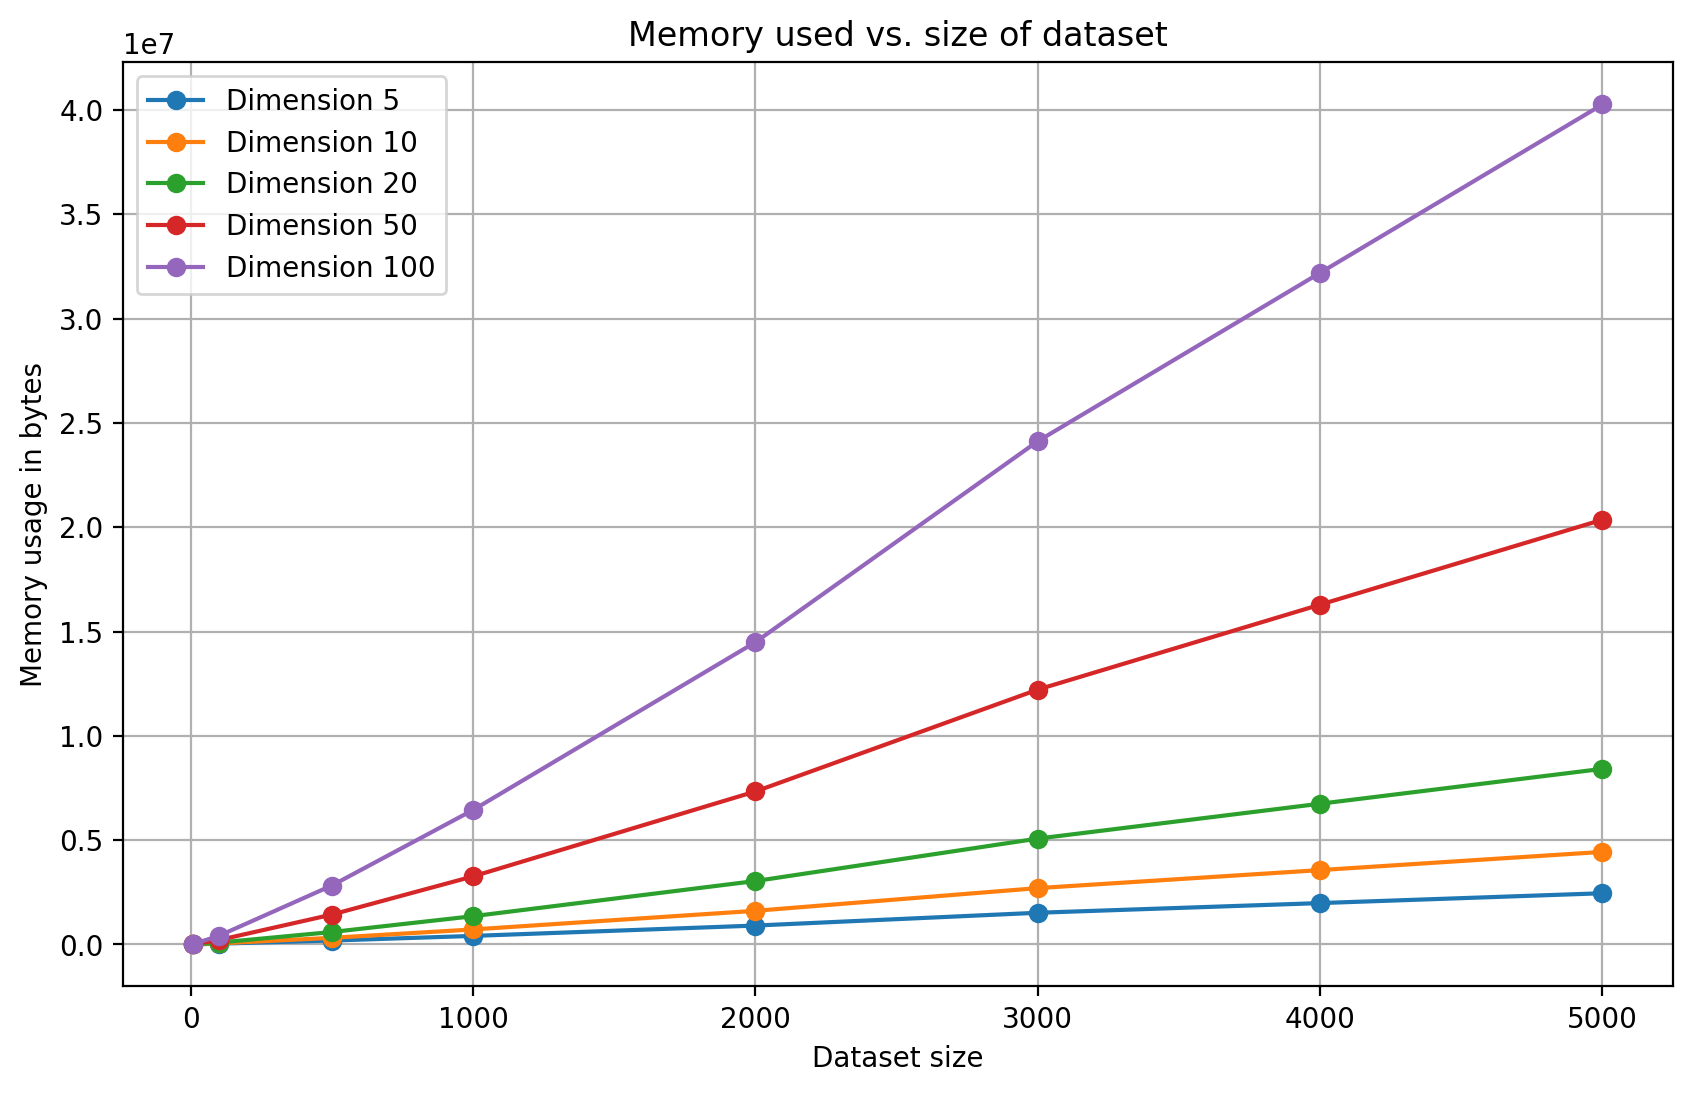

In [104]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()

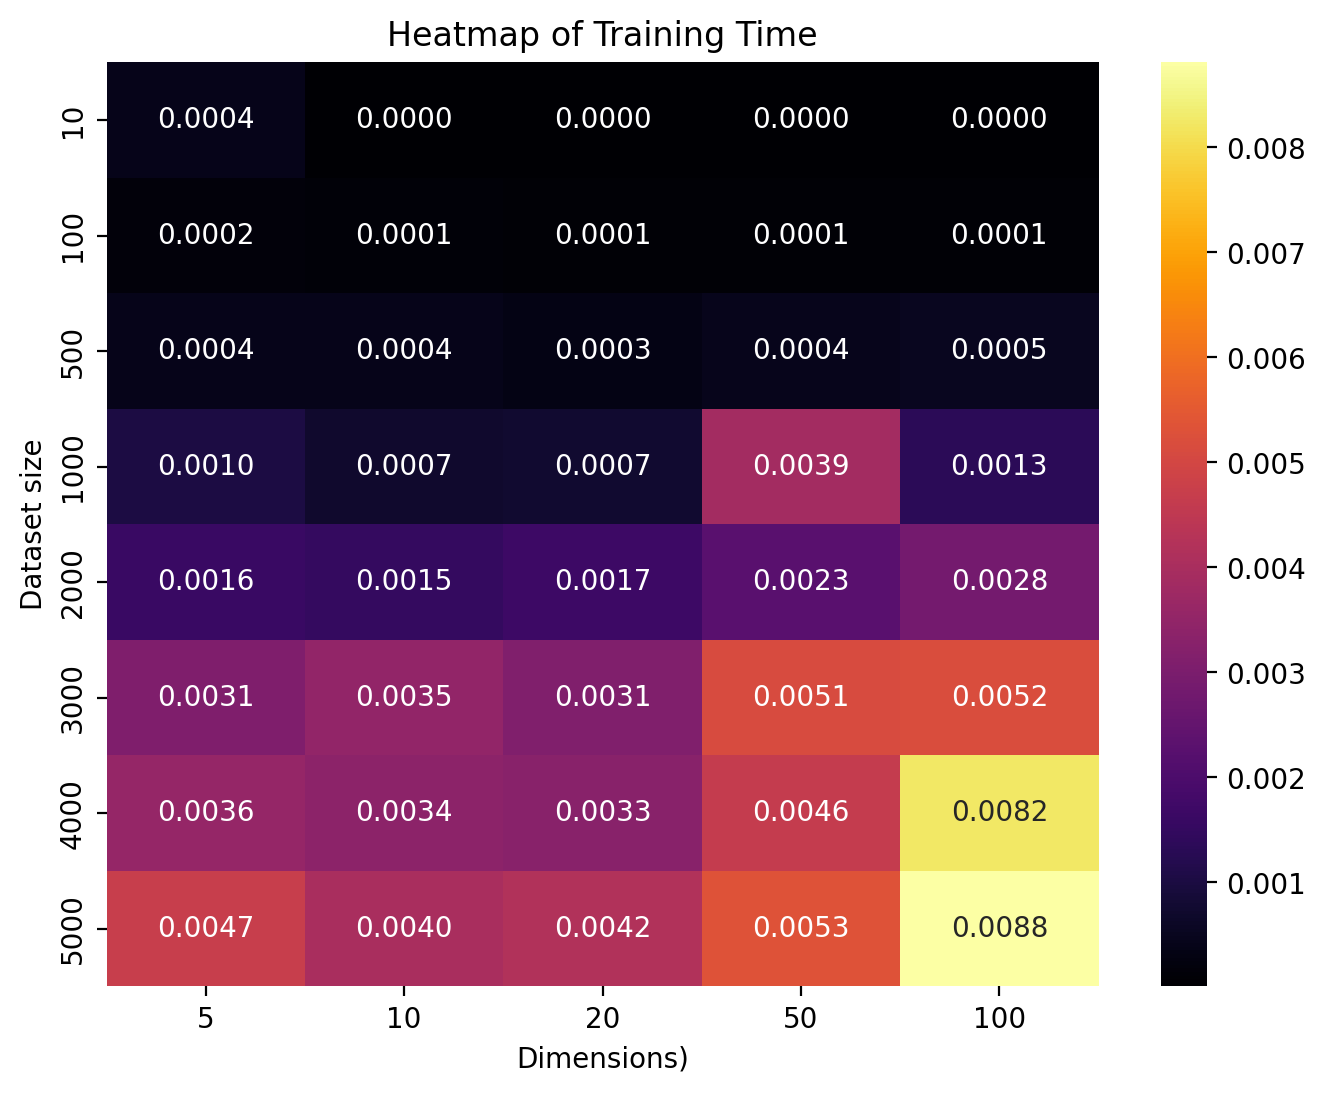

In [105]:
#plotting heatmap for visualization in 2d space
plt.figure(figsize=(8, 6))
sns.heatmap(training_times_KD_tree, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Dataset size')
plt.title('Heatmap of Training Time')
plt.show()

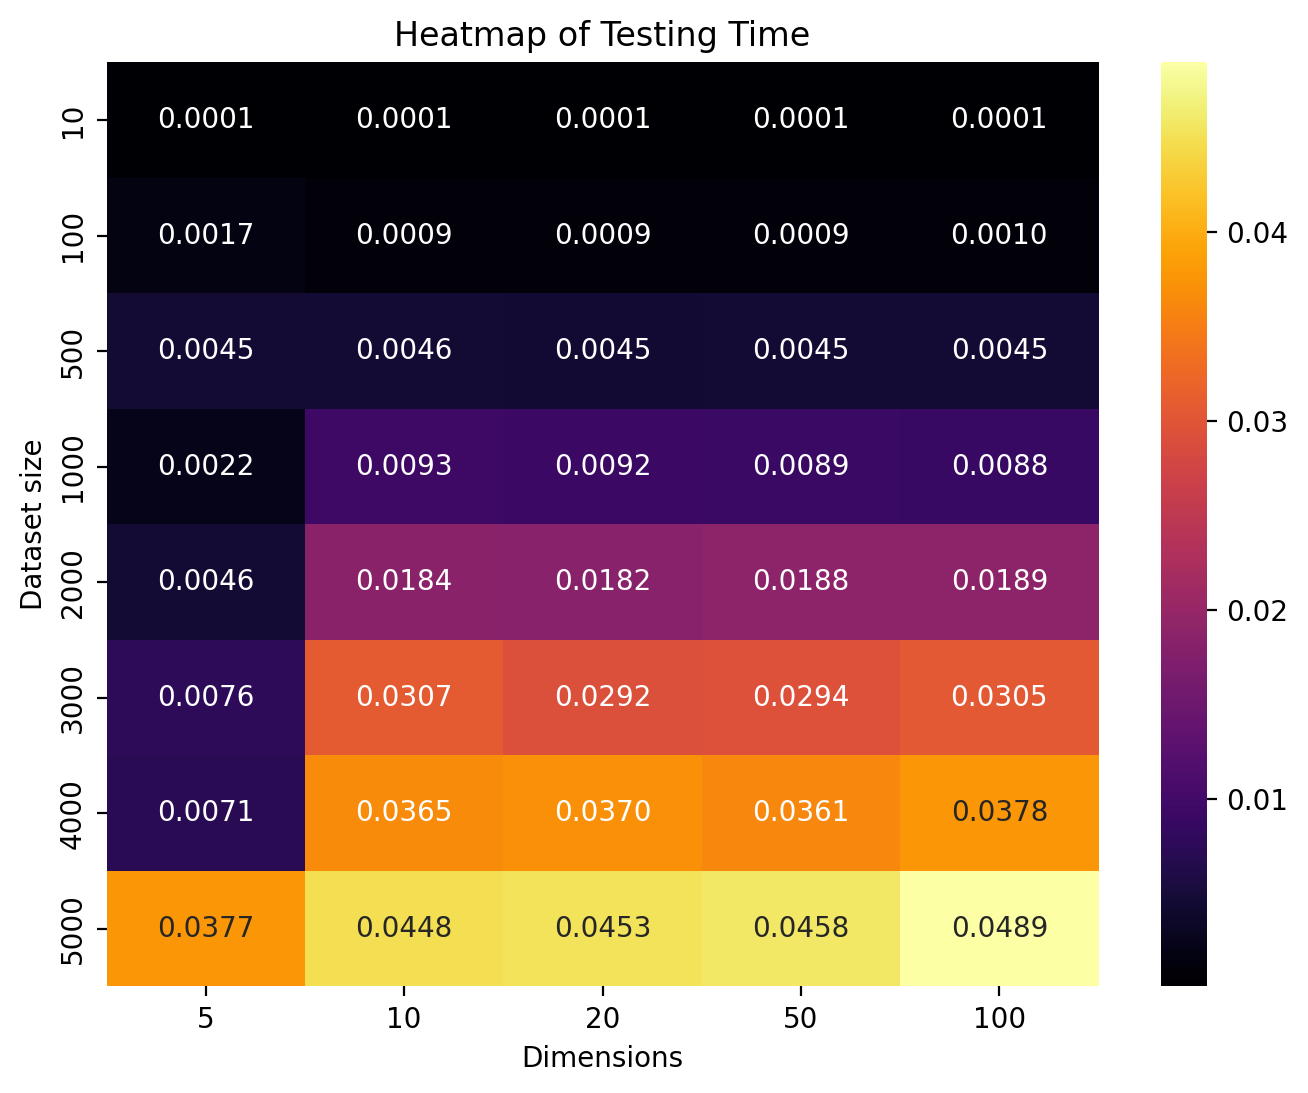

In [106]:
#heatmap of testing time

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_KD_tree, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

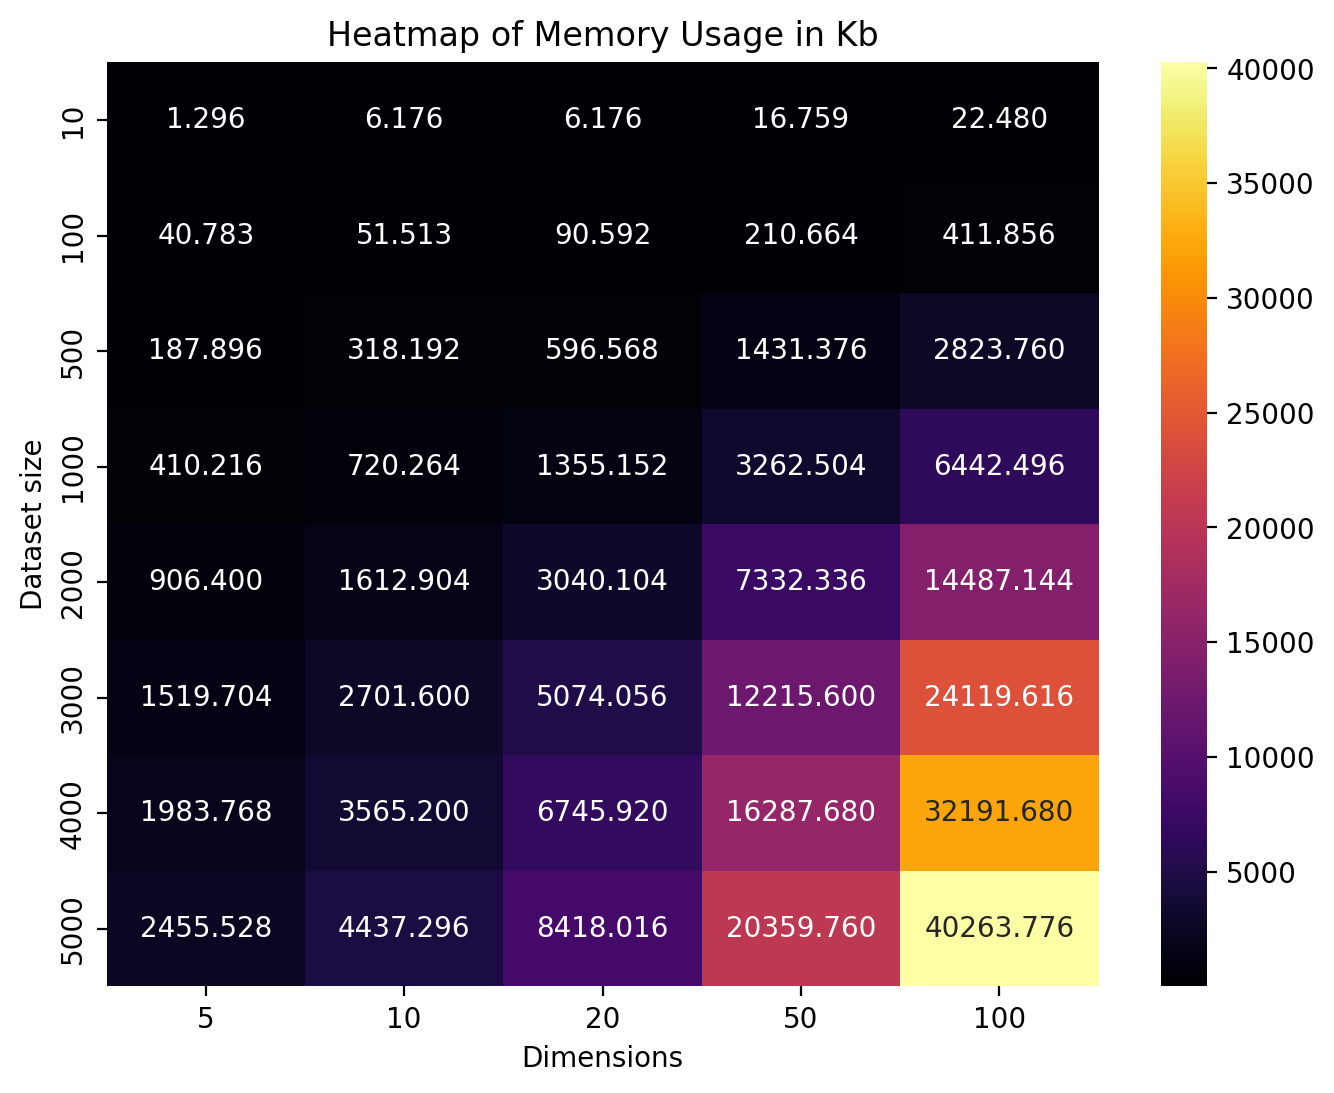

In [133]:
#heatmap of memory usage

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_KD_tree/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in Kb')
plt.show()


# LSH 

In [134]:
class LSH:
    def __init__(self, dataset, num_hashes=5):
        self.dataset = dataset
        self.num_hashes = num_hashes
        self.dataset_augmented = np.hstack((self.dataset, np.ones((self.dataset.shape[0], 1))))  # Adding bias term
        self.hashes = self._generate_hashes()  
        self.hash_buckets = self._create_hash_buckets()  # storing hash buckets (Training)

    def _generate_hashes(self):
        return np.random.randn(self.num_hashes, self.dataset.shape[1] + 1)

    def _hash_(self, point):
        point_augmented = np.append(point, 1)  
        return np.sign(np.dot(self.hashes, point_augmented))

    def _create_hash_buckets(self):
        
        hash_buckets = {}
        for index, point in enumerate(self.dataset):
            point_hash = tuple(self._hash_(point))  
            if point_hash not in hash_buckets:
                hash_buckets[point_hash] = []
            hash_buckets[point_hash].append(index)
        return hash_buckets  

    def query(self, query, K):
        
        query_hash = tuple(self._hash_(query))
        
        nearest_neighbors = self.find_k(query, self.hash_buckets.get(query_hash, []), K)

        if len(nearest_neighbors) < K: ## neighbouring buckets
            for i in range(self.num_hashes):
                if len(nearest_neighbors) >= K:
                    break
                modified_query_hash = list(query_hash)
                modified_query_hash[i] = 1 - modified_query_hash[i]  # Flipping the ith hash bit
                modified_query_hash_tuple = tuple(modified_query_hash)
                
                if modified_query_hash_tuple in self.hash_buckets:
                    remaining_neighbors = self.find_k(query, self.hash_buckets[modified_query_hash_tuple], K - len(nearest_neighbors))
                    nearest_neighbors.extend(remaining_neighbors)

        # Sorting again
        nearest_neighbors = sorted(nearest_neighbors, key=lambda x: x[1])[:K]
        nearest_indices = [index for index, _ in nearest_neighbors]
        nearest_points = self.dataset[nearest_indices]
        nearest_distances = [dist for _, dist in nearest_neighbors]

        return nearest_indices, nearest_points, nearest_distances

    def find_k(self, query, bucket_indices, K):
        distances = []
        for index in bucket_indices:
            point = self.dataset[index]
            dist = distance(query, point)
            distances.append((index, dist))
        return sorted(distances, key=lambda x: x[1])[:K]

In [135]:
num_hashes = 15 

lsh = LSH(ds, num_hashes)  ## Training 
nearest_indices, nearest_points, nearest_distances = lsh.query(q, K)  # Testing

print("Query Point:", q)
print(nearest_indices)
print(nearest_points)
print(nearest_distances)

Query Point: [0.33771962 0.6626352 ]
[197, 150, 171, 52, 98, 183, 160, 19, 50, 158]
[[0.36840323 0.67932601]
 [0.38637573 0.6110893 ]
 [0.30061178 0.59701655]
 [0.35713493 0.58978199]
 [0.2594804  0.69239925]
 [0.31789849 0.57200881]
 [0.42854028 0.62900946]
 [0.3508719  0.55097791]
 [0.22957403 0.7046275 ]
 [0.30636467 0.77579791]]
[np.float64(0.03492945917232921), np.float64(0.07088297633172284), np.float64(0.07538434197363751), np.float64(0.0753959180857742), np.float64(0.08370945798987765), np.float64(0.09276863347305683), np.float64(0.09684566610574522), np.float64(0.11242924032879546), np.float64(0.11601216398668093), np.float64(0.11742628283905716)]


Testing

In [136]:
hashes = 15

In [155]:
#varying the data_set size and the number of dimensions

training_times_LSH = np.zeros((len(dataset_size), len(dimensions)))
testing_times_LSH = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_LSH_train = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_LSH_test = np.zeros((len(dataset_size), len(dimensions)))


for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        start_train_time = time.time()
        lsh = LSH(ds, num_hashes=15)
        end_train_time = time.time()
        training_times_LSH[i, j] = end_train_time - start_train_time
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_LSH_train[i, j] = peak
        
        tracemalloc.clear_traces()

        tracemalloc.start()
        
        start_test_time = time.time()
        indices, points, distances = lsh.query(q, K)
        end_test_time = time.time()
        testing_times_LSH[i, j] = end_test_time - start_test_time

        current, peak = tracemalloc.get_traced_memory()
        memory_usage_LSH_test[i, j] = peak

        tracemalloc.clear_traces()

tracemalloc.stop()


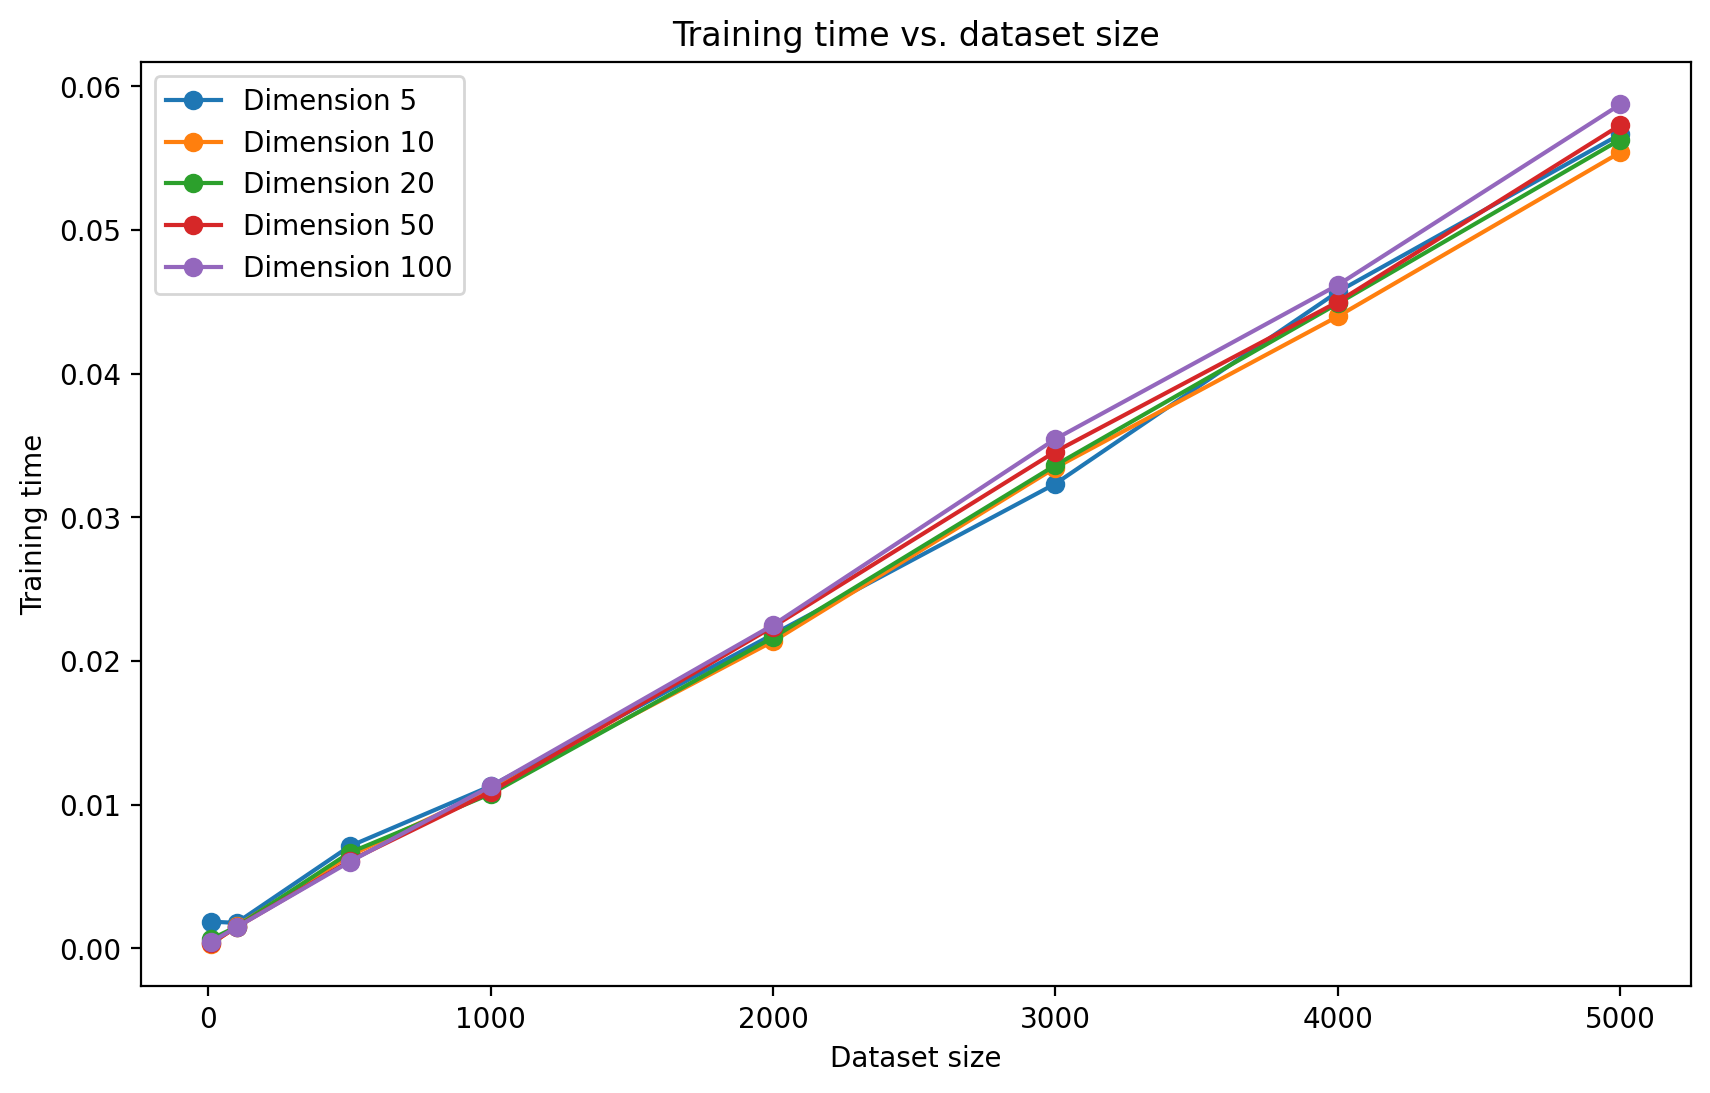

In [156]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, training_times_LSH[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Training time')
plt.title('Training time vs. dataset size')
plt.legend()


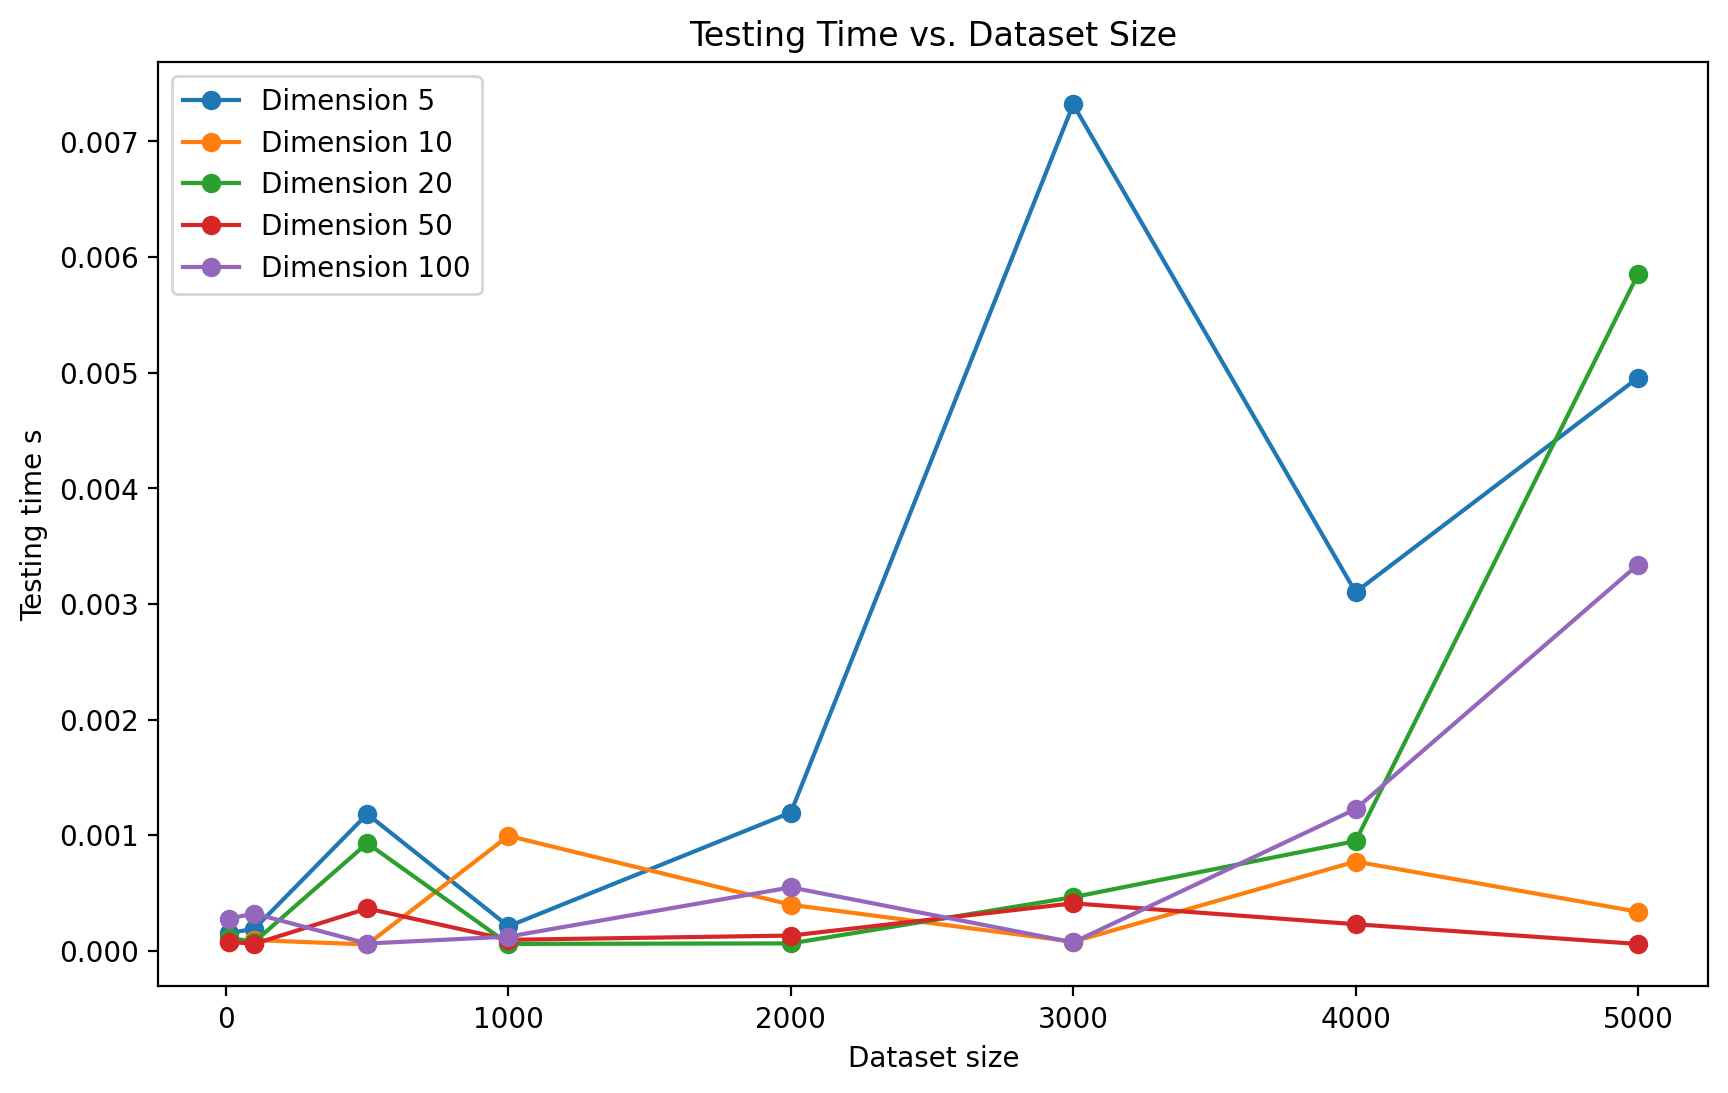

In [157]:
#testing time

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_LSH[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Testing time s')
plt.title('Testing Time vs. Dataset Size')
plt.legend()


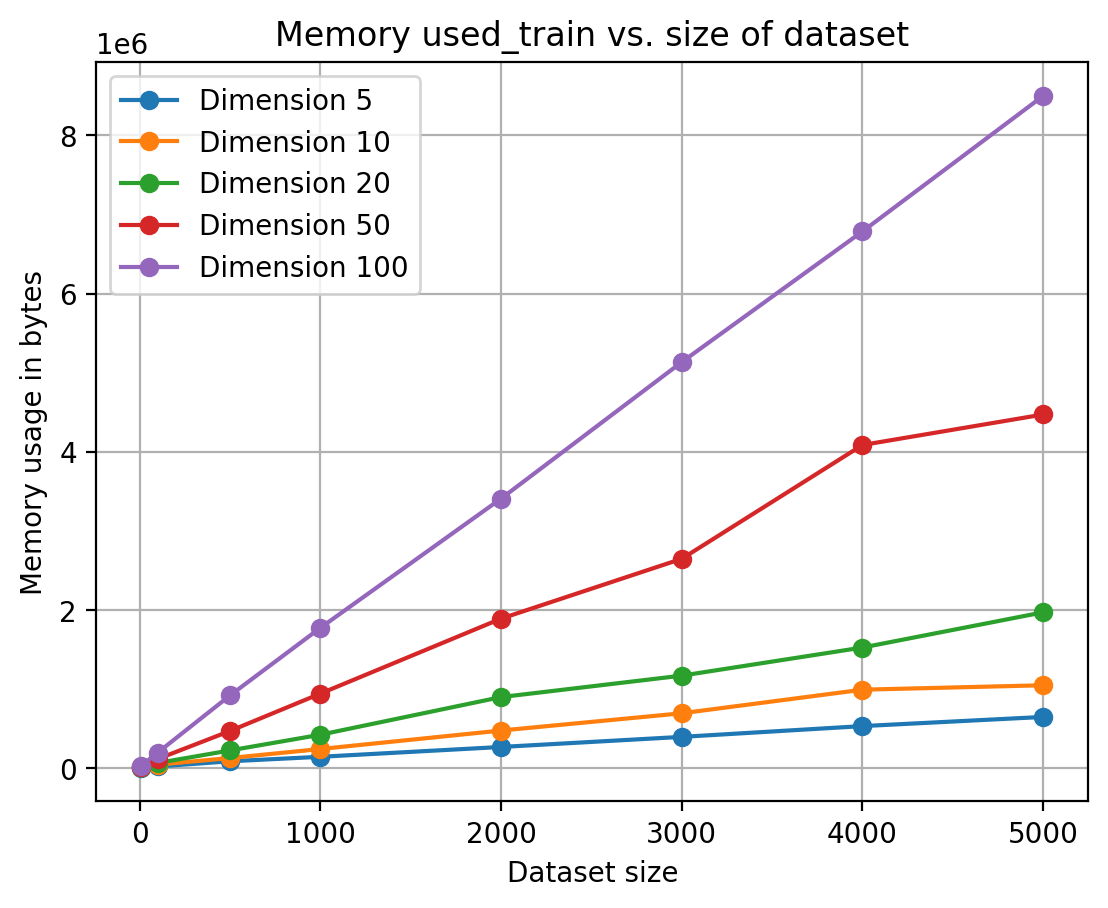

In [145]:
#memory used for training
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_LSH_train[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used_train vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()


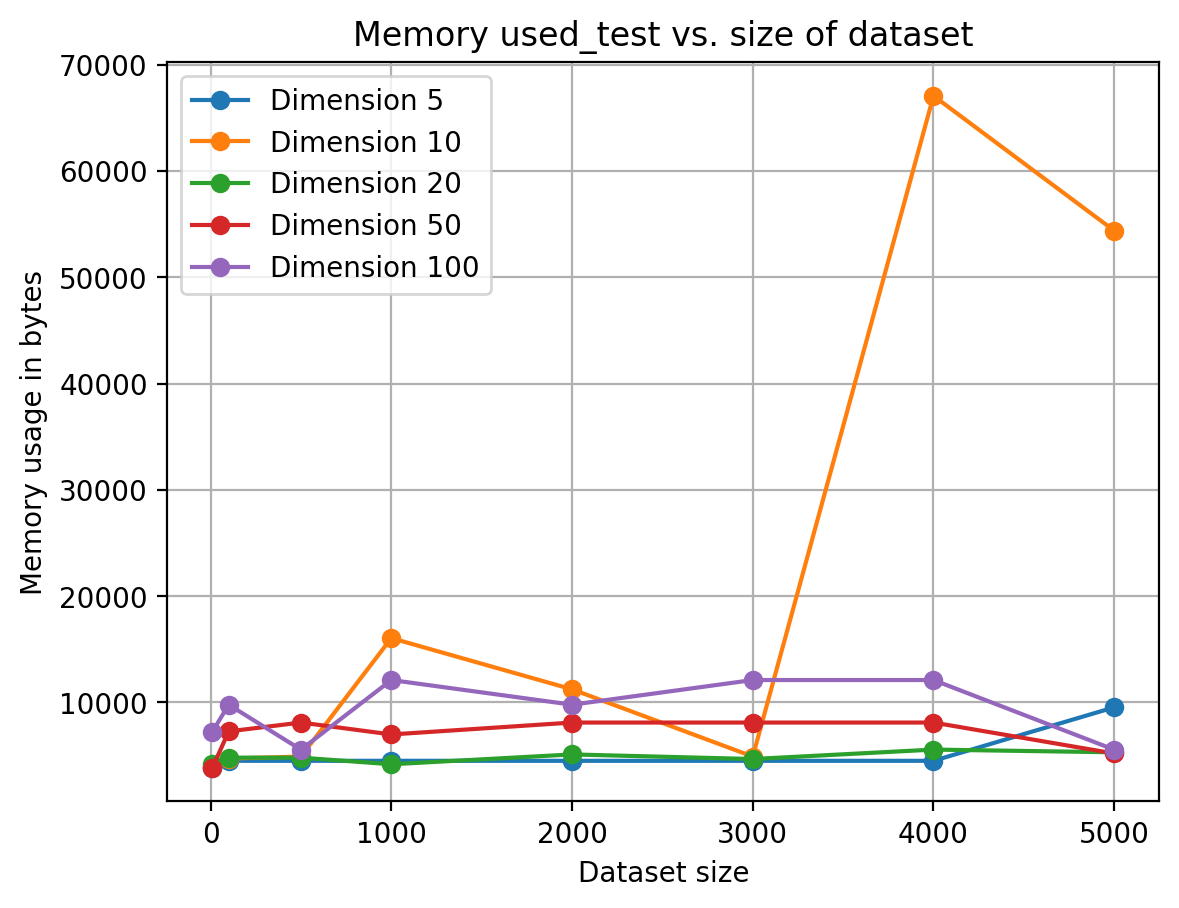

In [115]:
#memory used for testing with varing dimensions and data set size

for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_LSH_test[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used_test vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()

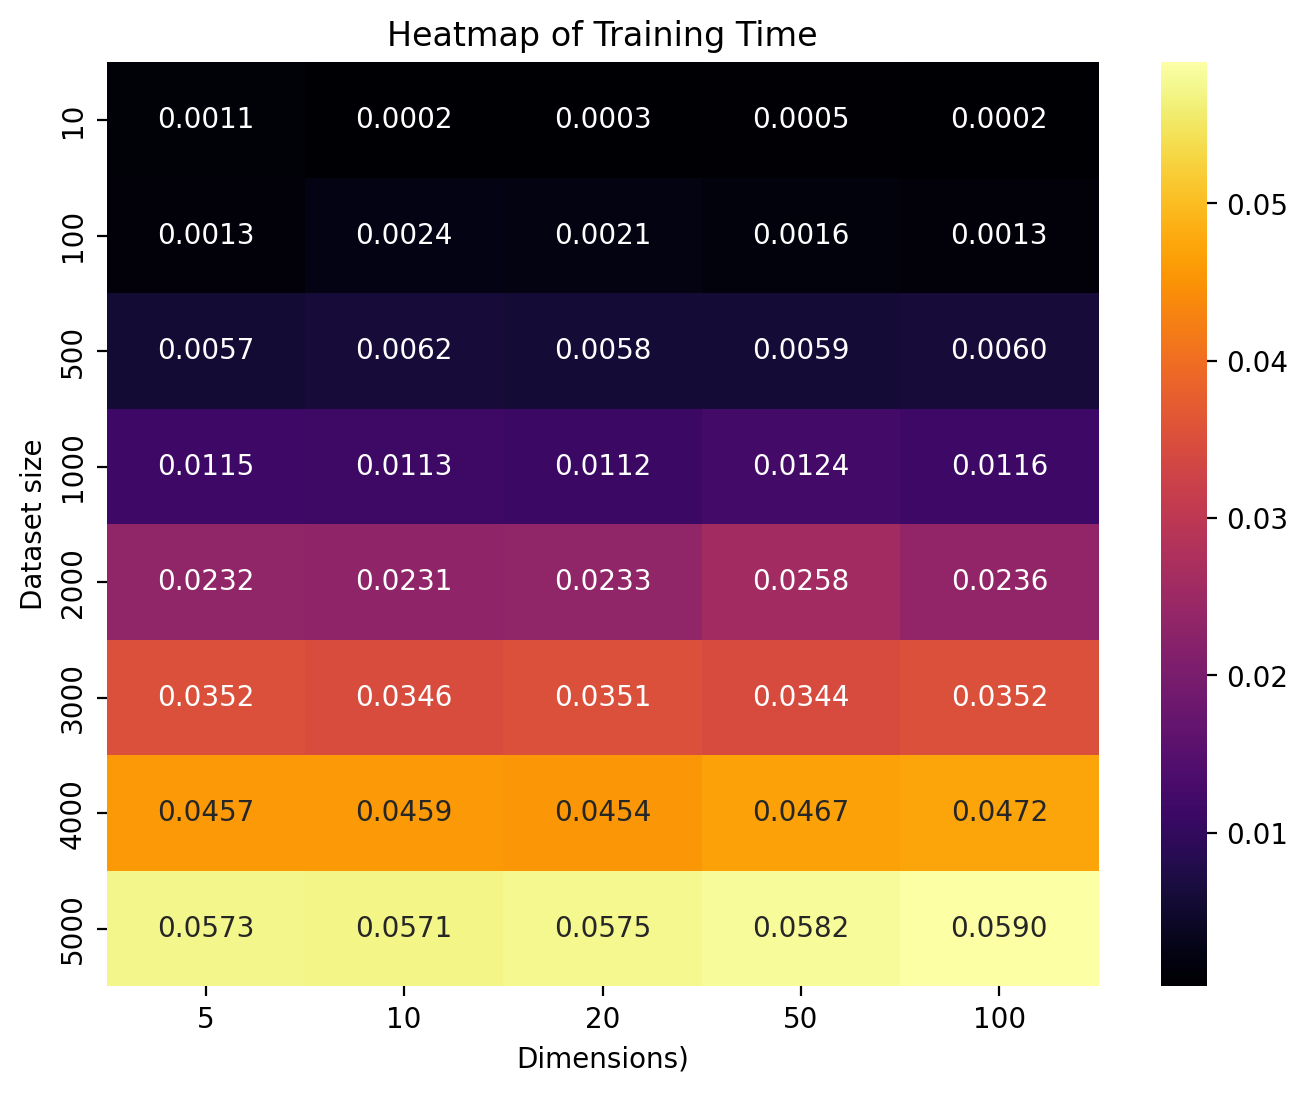

In [116]:
#plotting heatmaps for trainign time vs varying dimensions and dataset size

#plotting heatmap for visualization in 2d space
plt.figure(figsize=(8, 6))
sns.heatmap(training_times_LSH, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Dataset size')
plt.title('Heatmap of Training Time')
plt.show()

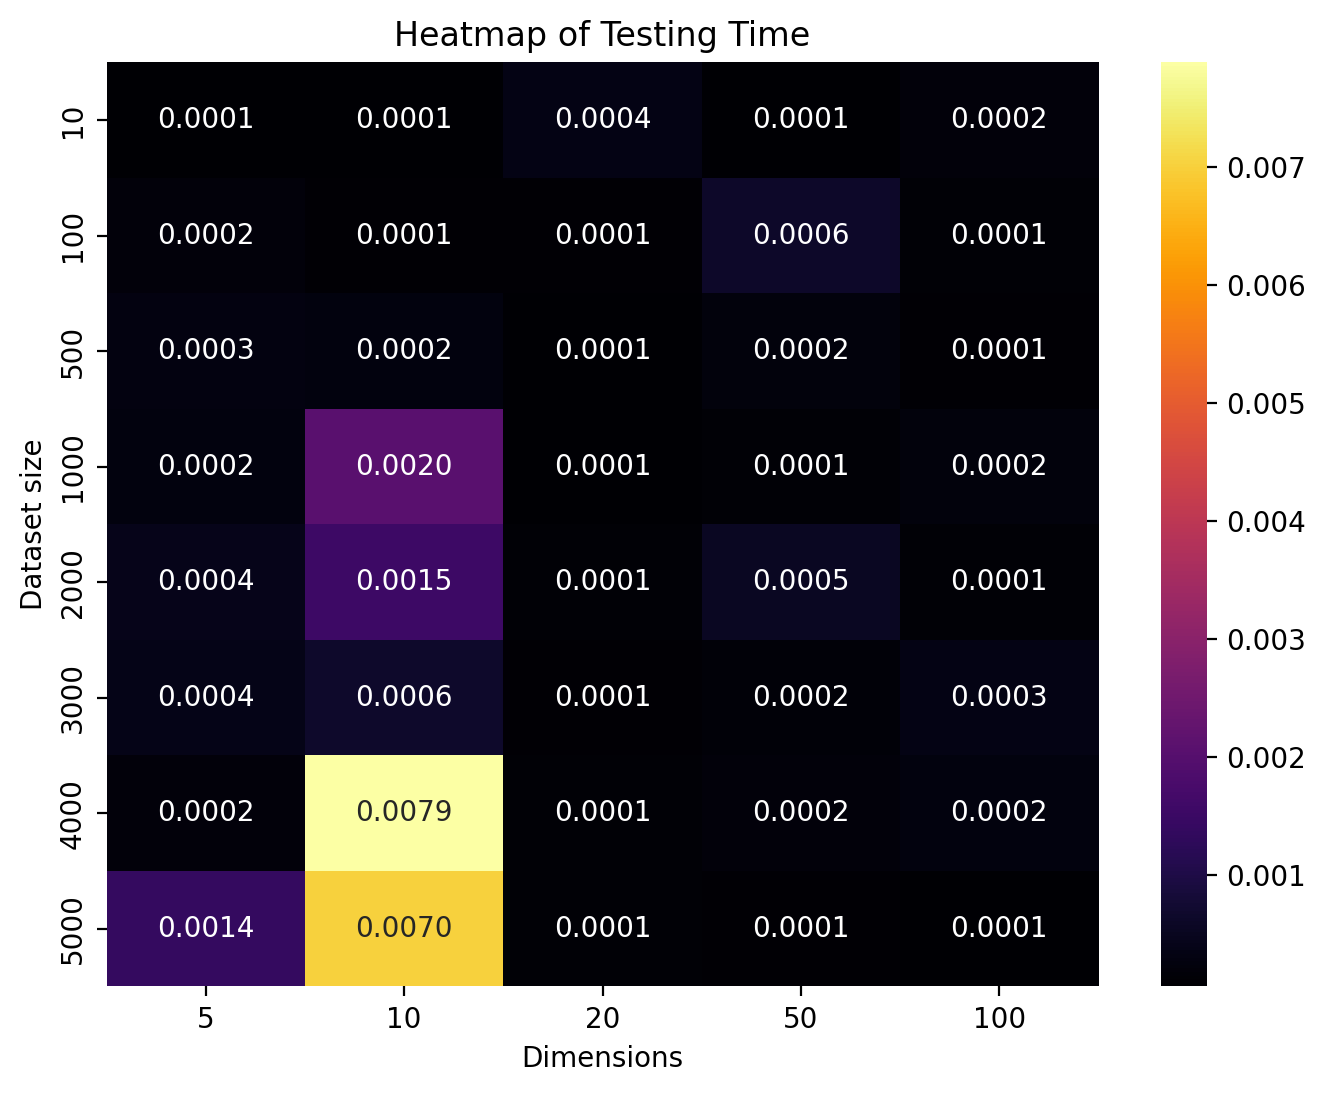

In [117]:
#heatmap for testing time for varying dataset size and the number of dimensions

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_LSH, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

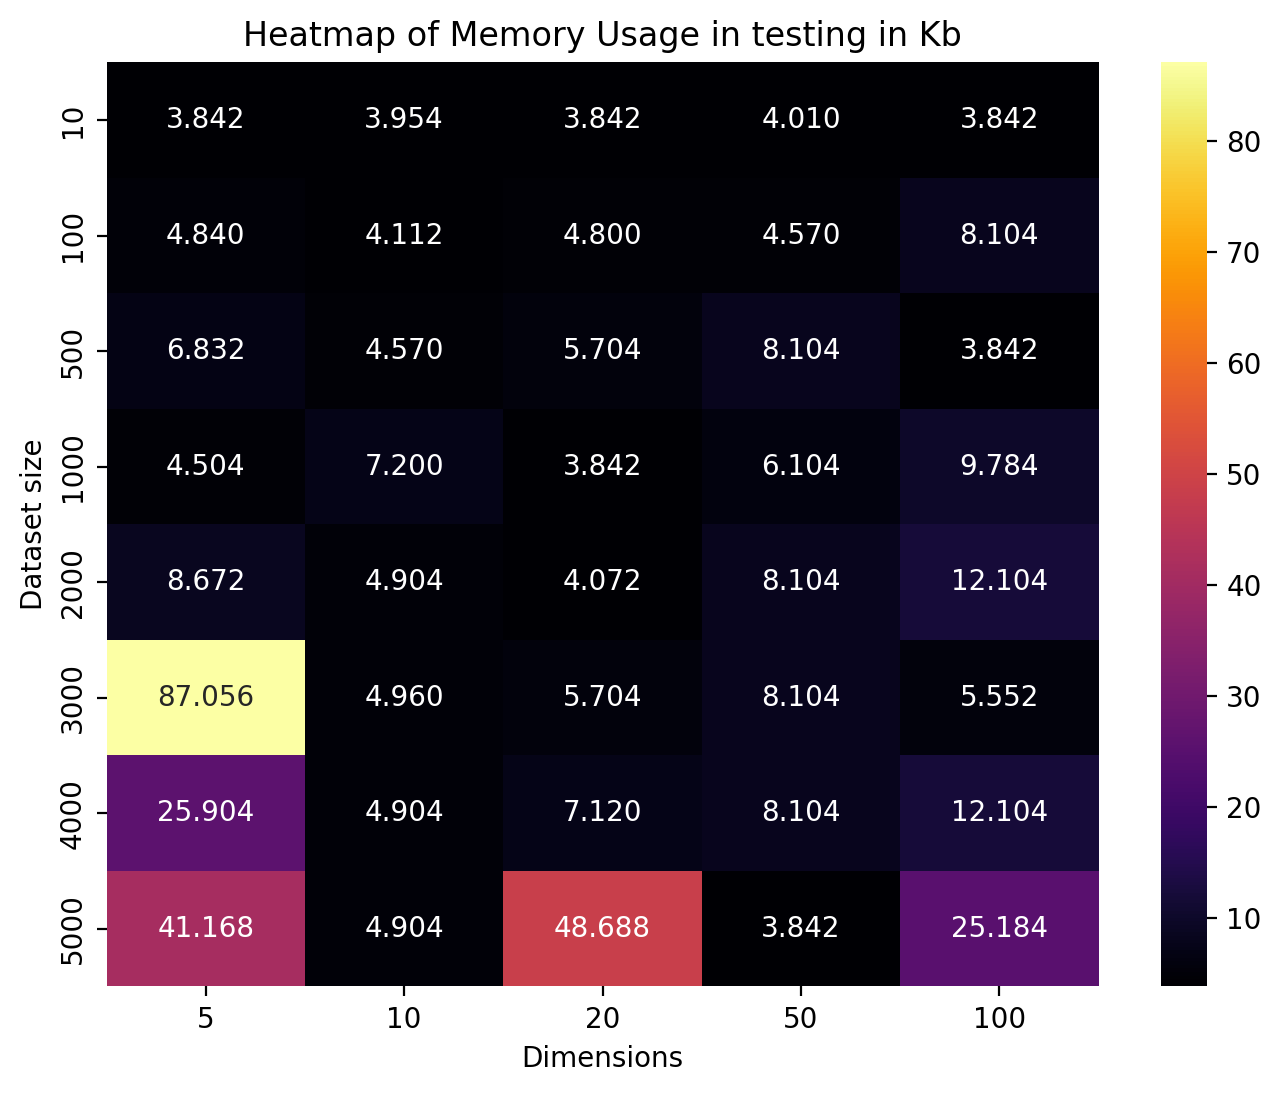

In [160]:
#heatmap of memory required for testing

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_LSH_test/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in testing in Kb')
plt.show()

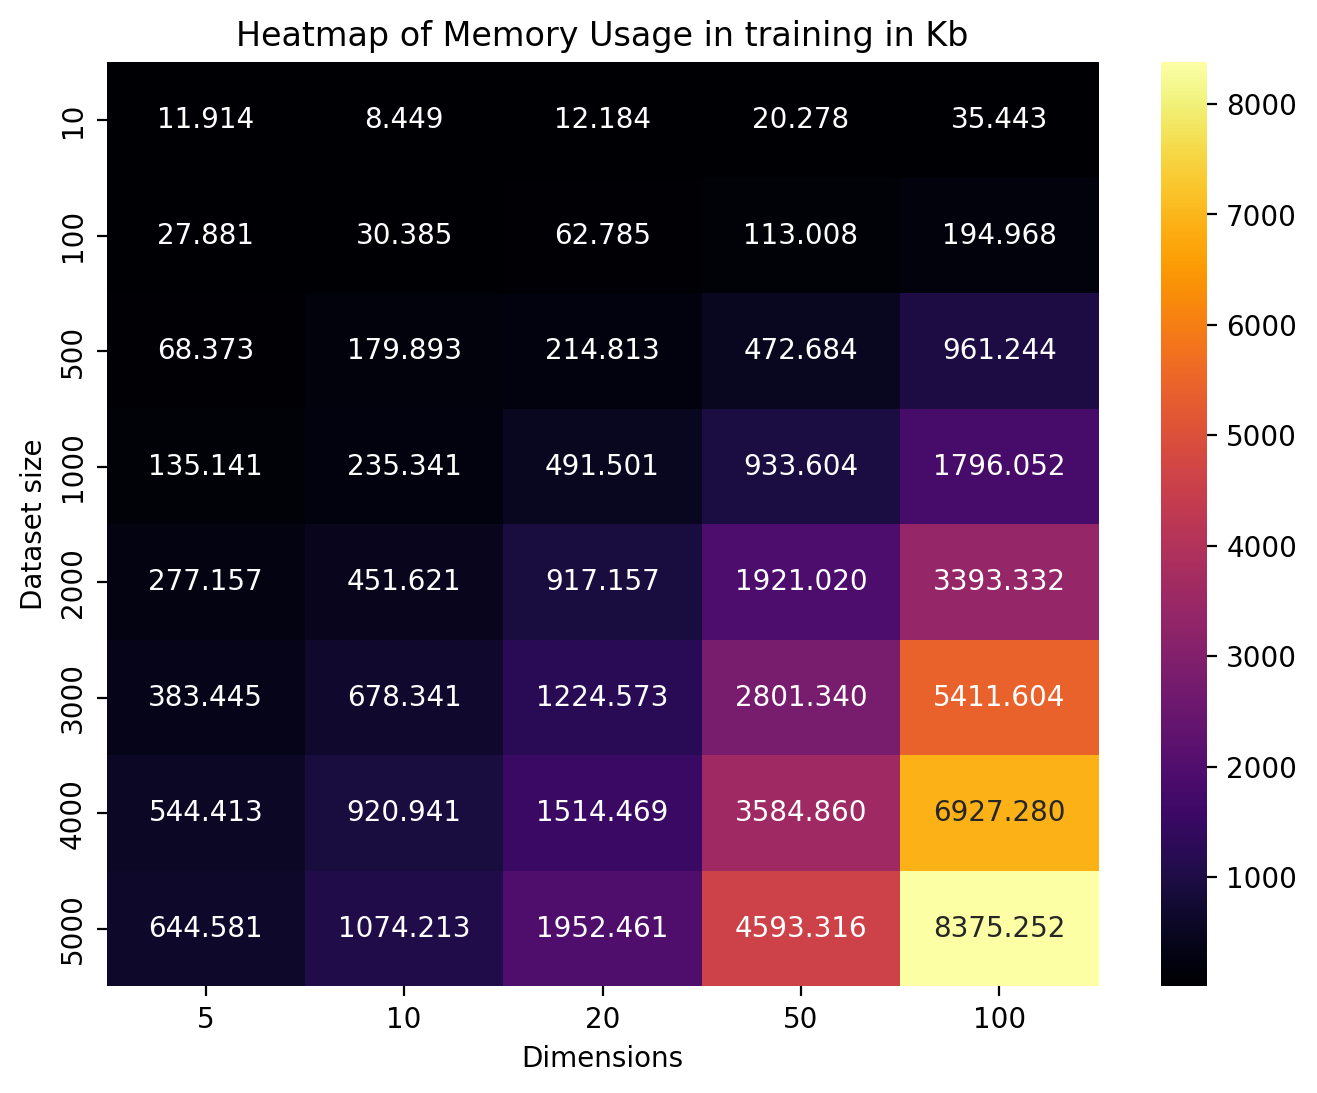

In [159]:
#heatmap of memory required for testing

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_LSH_train/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in training in Kb')
plt.show()

## Naive KNN testing

In [161]:
# there is no training, only testing is the phase which consumes a lot of time and requires high amt of memory

testing_times_naive = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_naive = np.zeros((len(dataset_size), len(dimensions)))

for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        # Testing time and memory usage for Naive KNN
        start_test_time_naive = time.time()
        indices_naive, points_naive, distances_naive = naive_knn(q, ds, K)
        end_test_time_naive = time.time()
        testing_times_naive[i, j] = end_test_time_naive - start_test_time_naive
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_naive[i, j] = peak
        
        tracemalloc.clear_traces()

tracemalloc.stop()

Plots


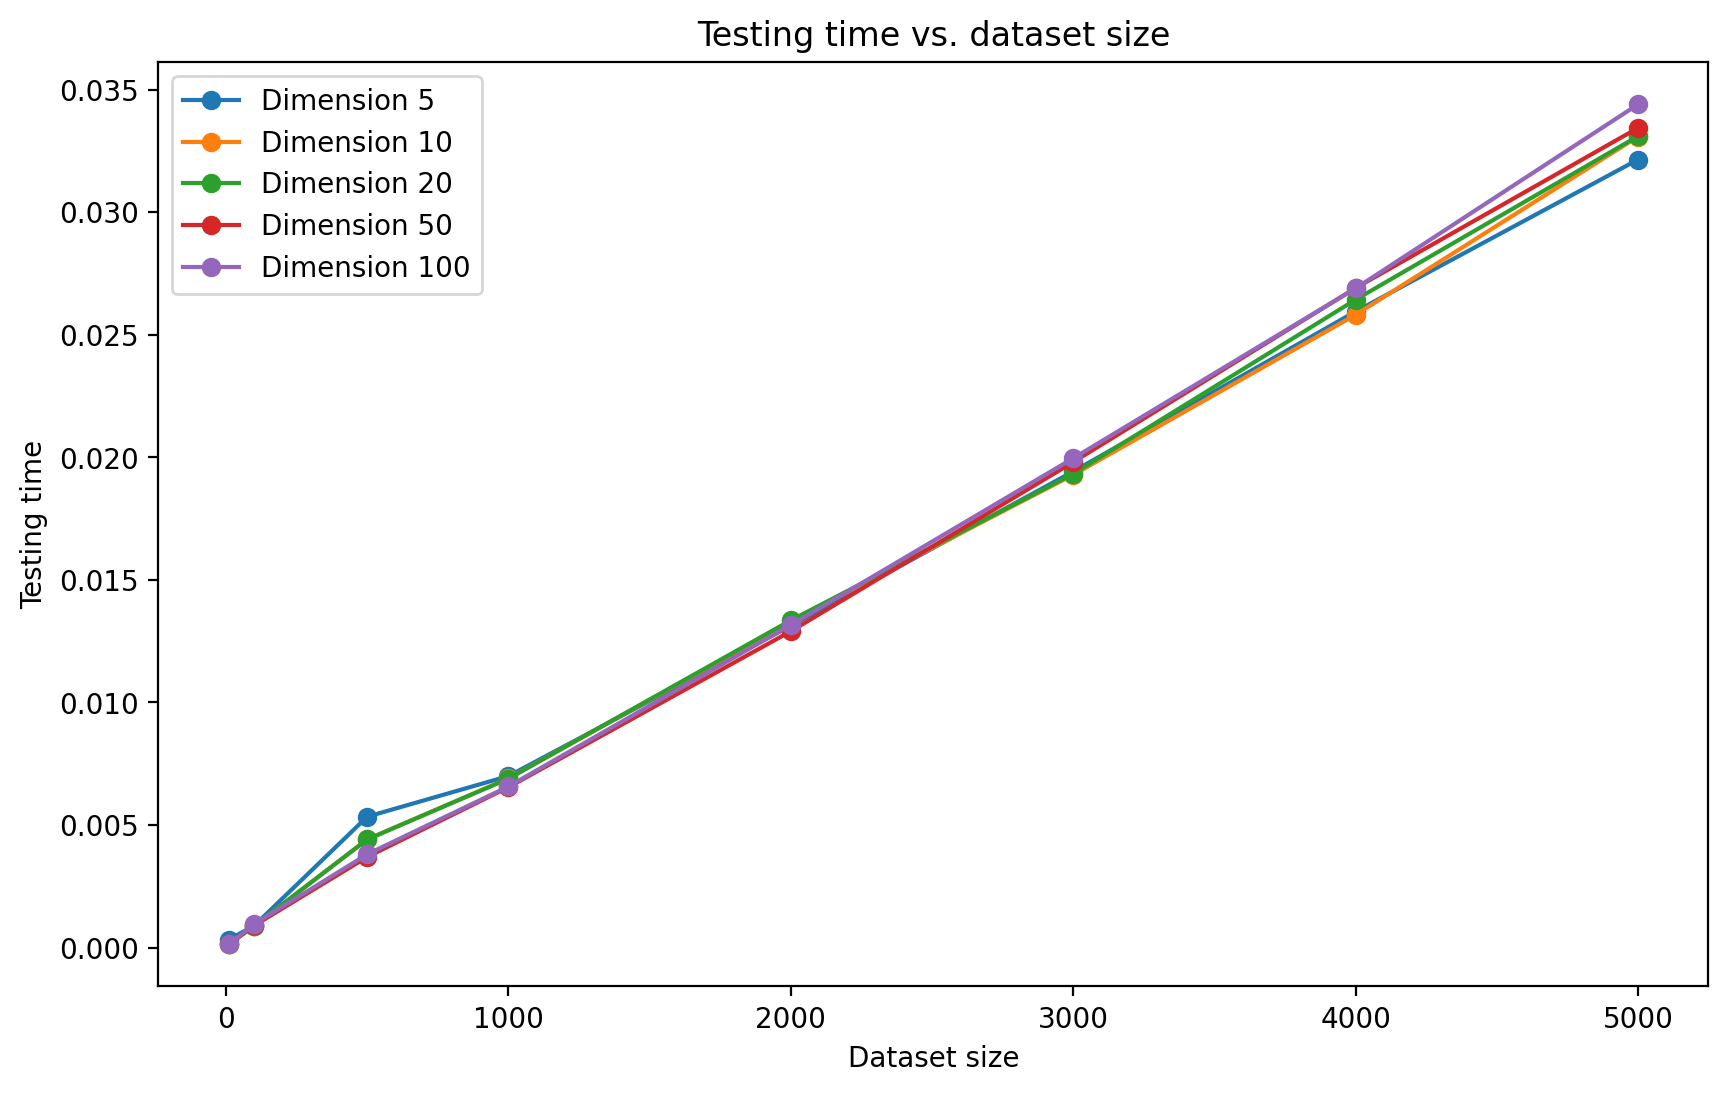

In [164]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_naive[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Testing time')
plt.title('Testing time vs. dataset size')
plt.legend()

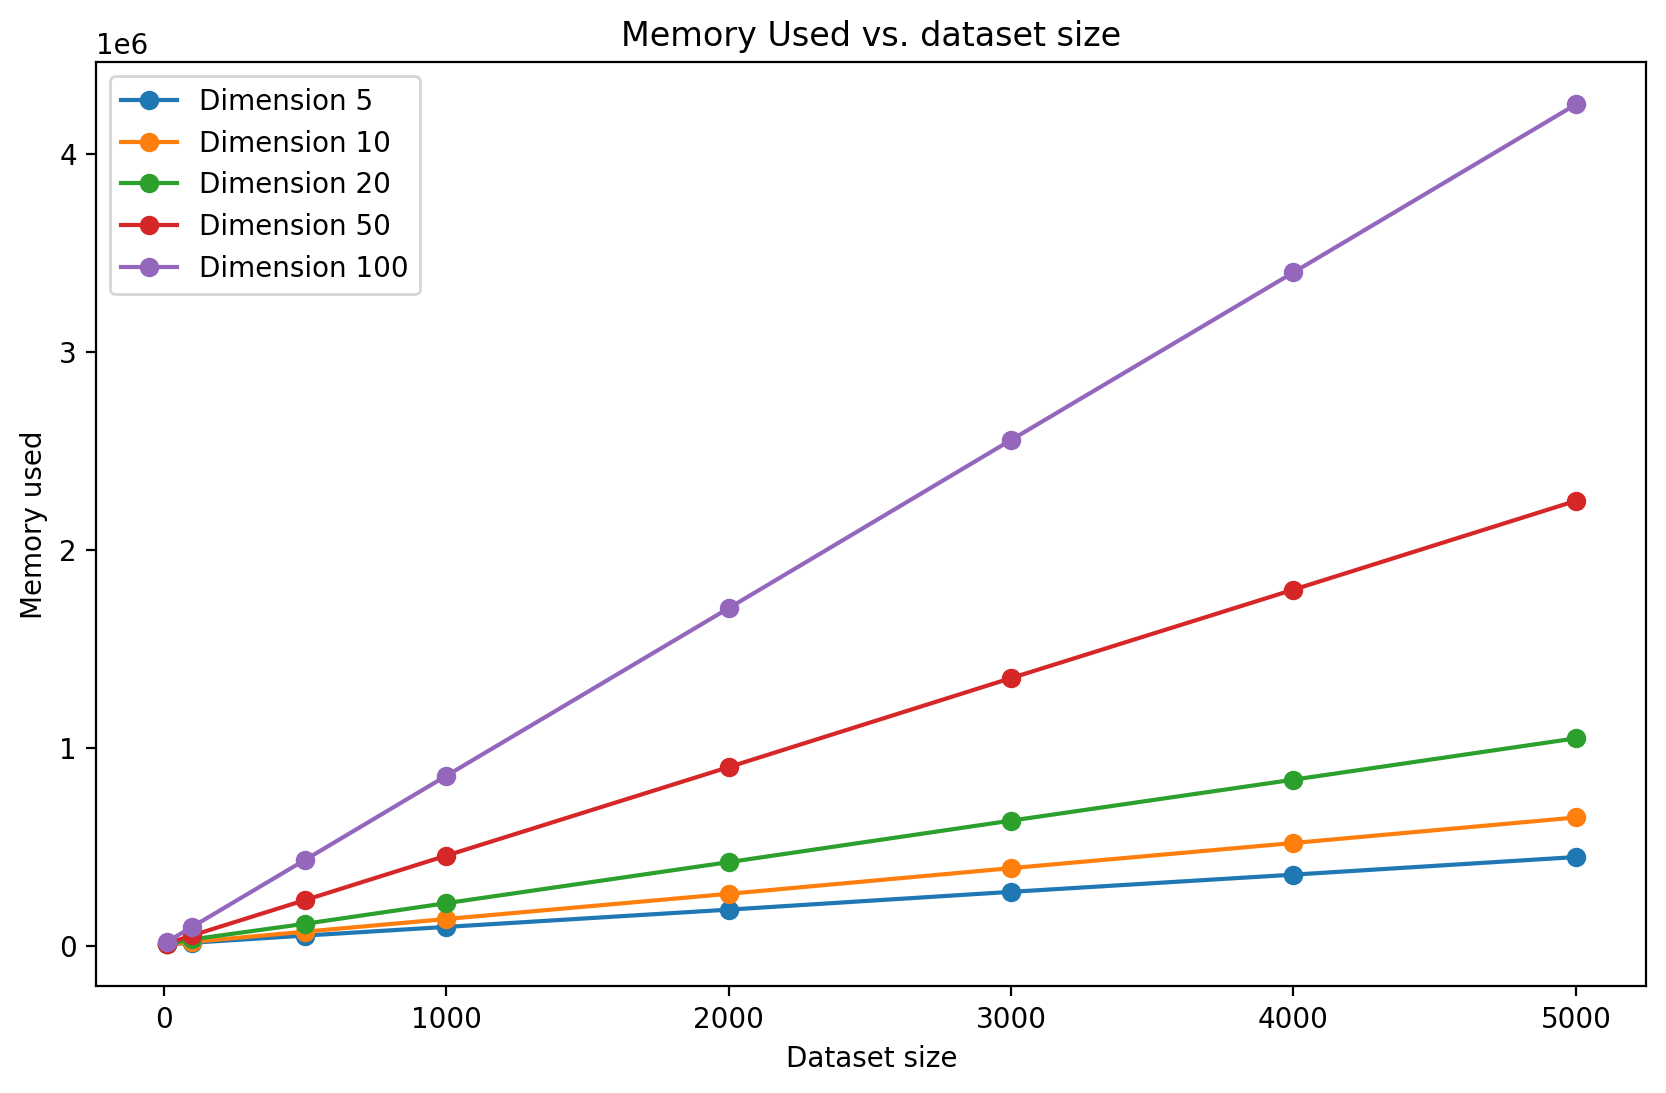

In [165]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_naive[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory used')
plt.title('Memory Used vs. dataset size')
plt.legend()

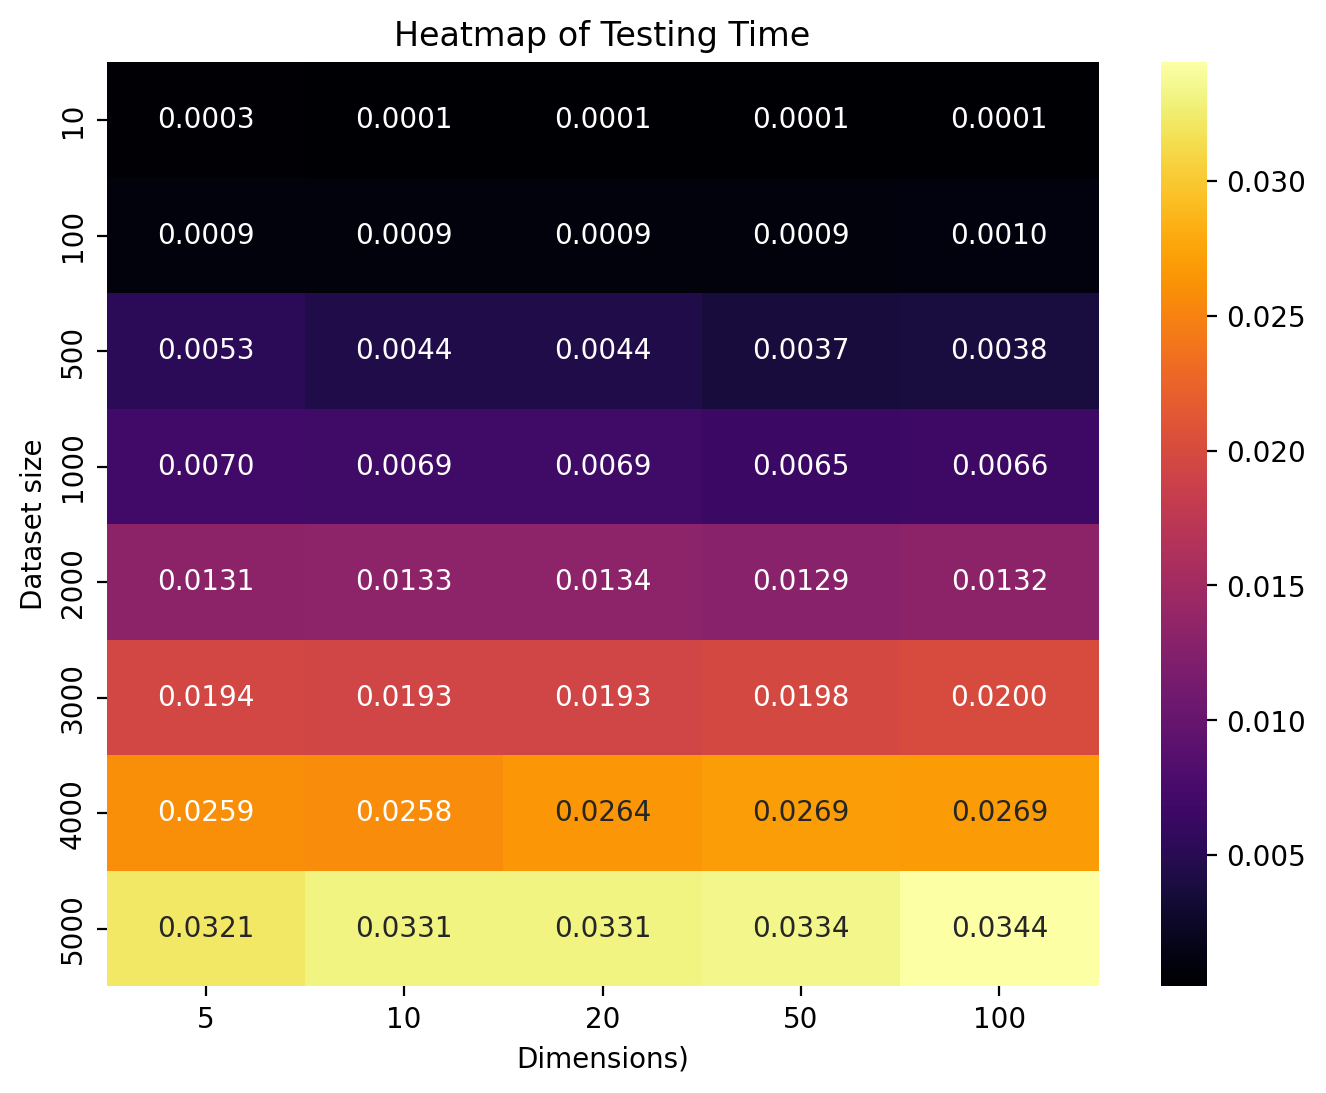

In [ ]:
#plotting the heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_naive, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

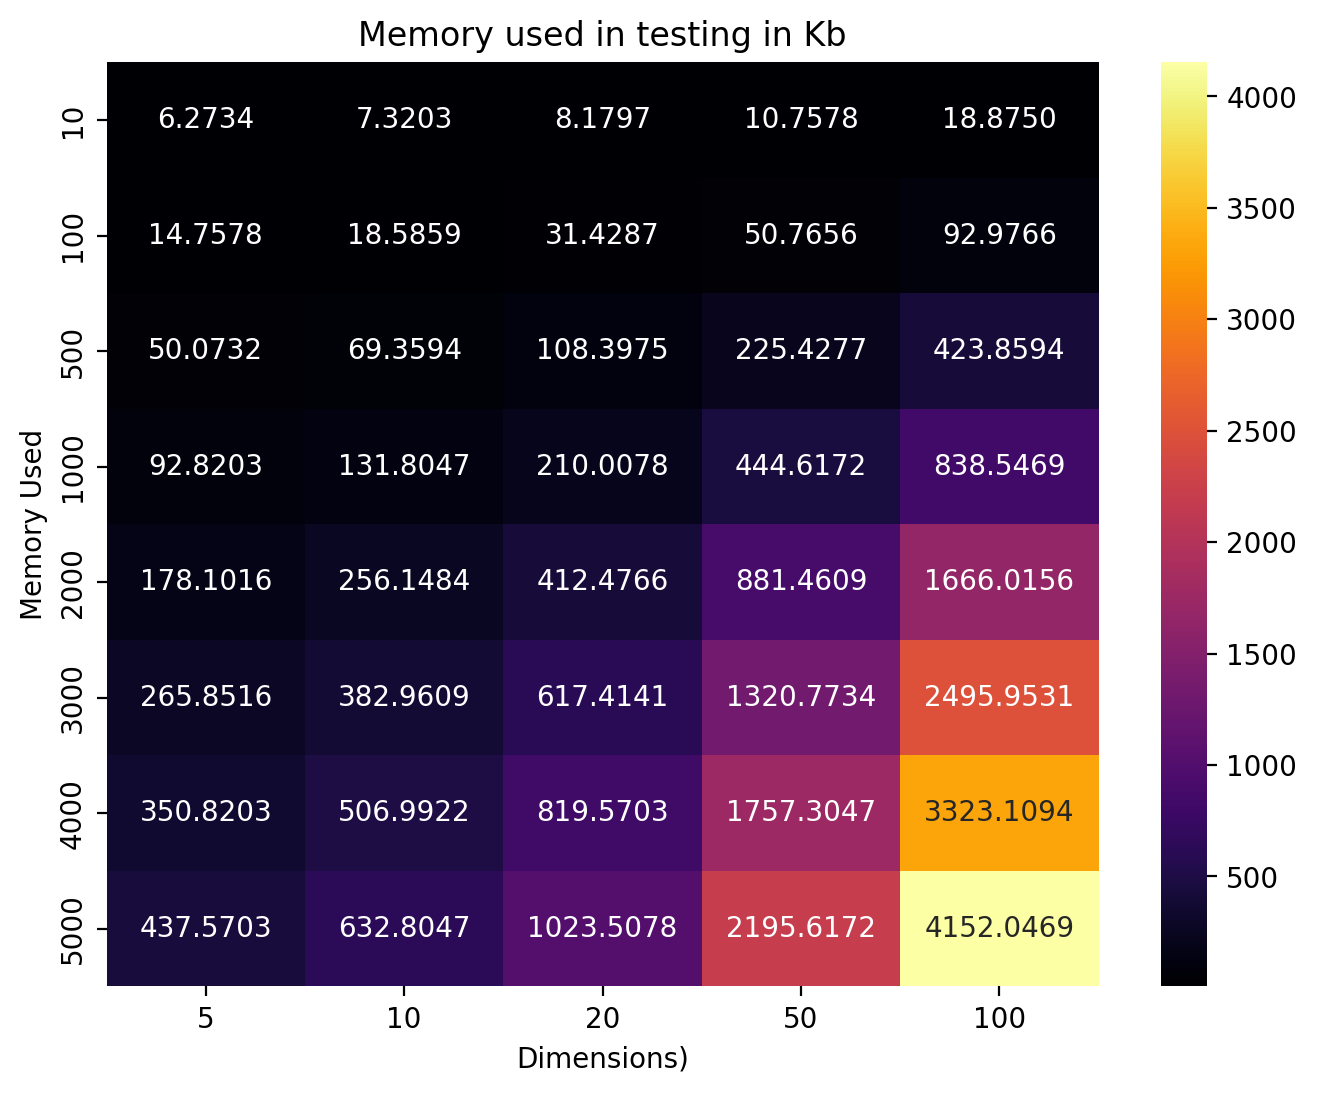

In [167]:
plt.figure(figsize=(8, 6))
memory_usage_naive = memory_usage_naive / 1024  # Converting bytes to kilobytes
sns.heatmap(memory_usage_naive, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Memory Used')
plt.title('Memory used in testing in Kb')
plt.show()

Part - 2

visualization of 2d data and how closest neighbors are missed in approximation behavior of LSH and KD tree

Question

Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature. 

In [168]:
#function to plot the partition


def plot_kdtree_partitions(node, depth=0, xmin=0, xmax=1, ymin=0, ymax=1):
    if isinstance(node, np.ndarray):
        return
    median, left, right = node
    axis = depth % 2
    if axis == 0:
        plt.plot([median[0], median[0]], [ymin, ymax], 'k--', color = 'red')  # Vertical line
        plot_kdtree_partitions(left, depth + 1, xmin, median[0], ymin, ymax)
        plot_kdtree_partitions(right, depth + 1, median[0], xmax, ymin, ymax)
    else:
        plt.plot([xmin, xmax], [median[1], median[1]], 'k--', color = 'black')  # Horizontal line
        plot_kdtree_partitions(left, depth + 1, xmin, xmax, ymin, median[1])
        plot_kdtree_partitions(right, depth + 1, xmin, xmax, median[1], ymax)


In [169]:
list_color = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'black', 'cyan']

/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_25493/3632460437.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([median[0], median[0]], [ymin, ymax], 'k--', color = 'red')  # Vertical line
/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_25493/3632460437.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([xmin, xmax], [median[1], median[1]], 'k--', color = 'black')  # Horizontal line


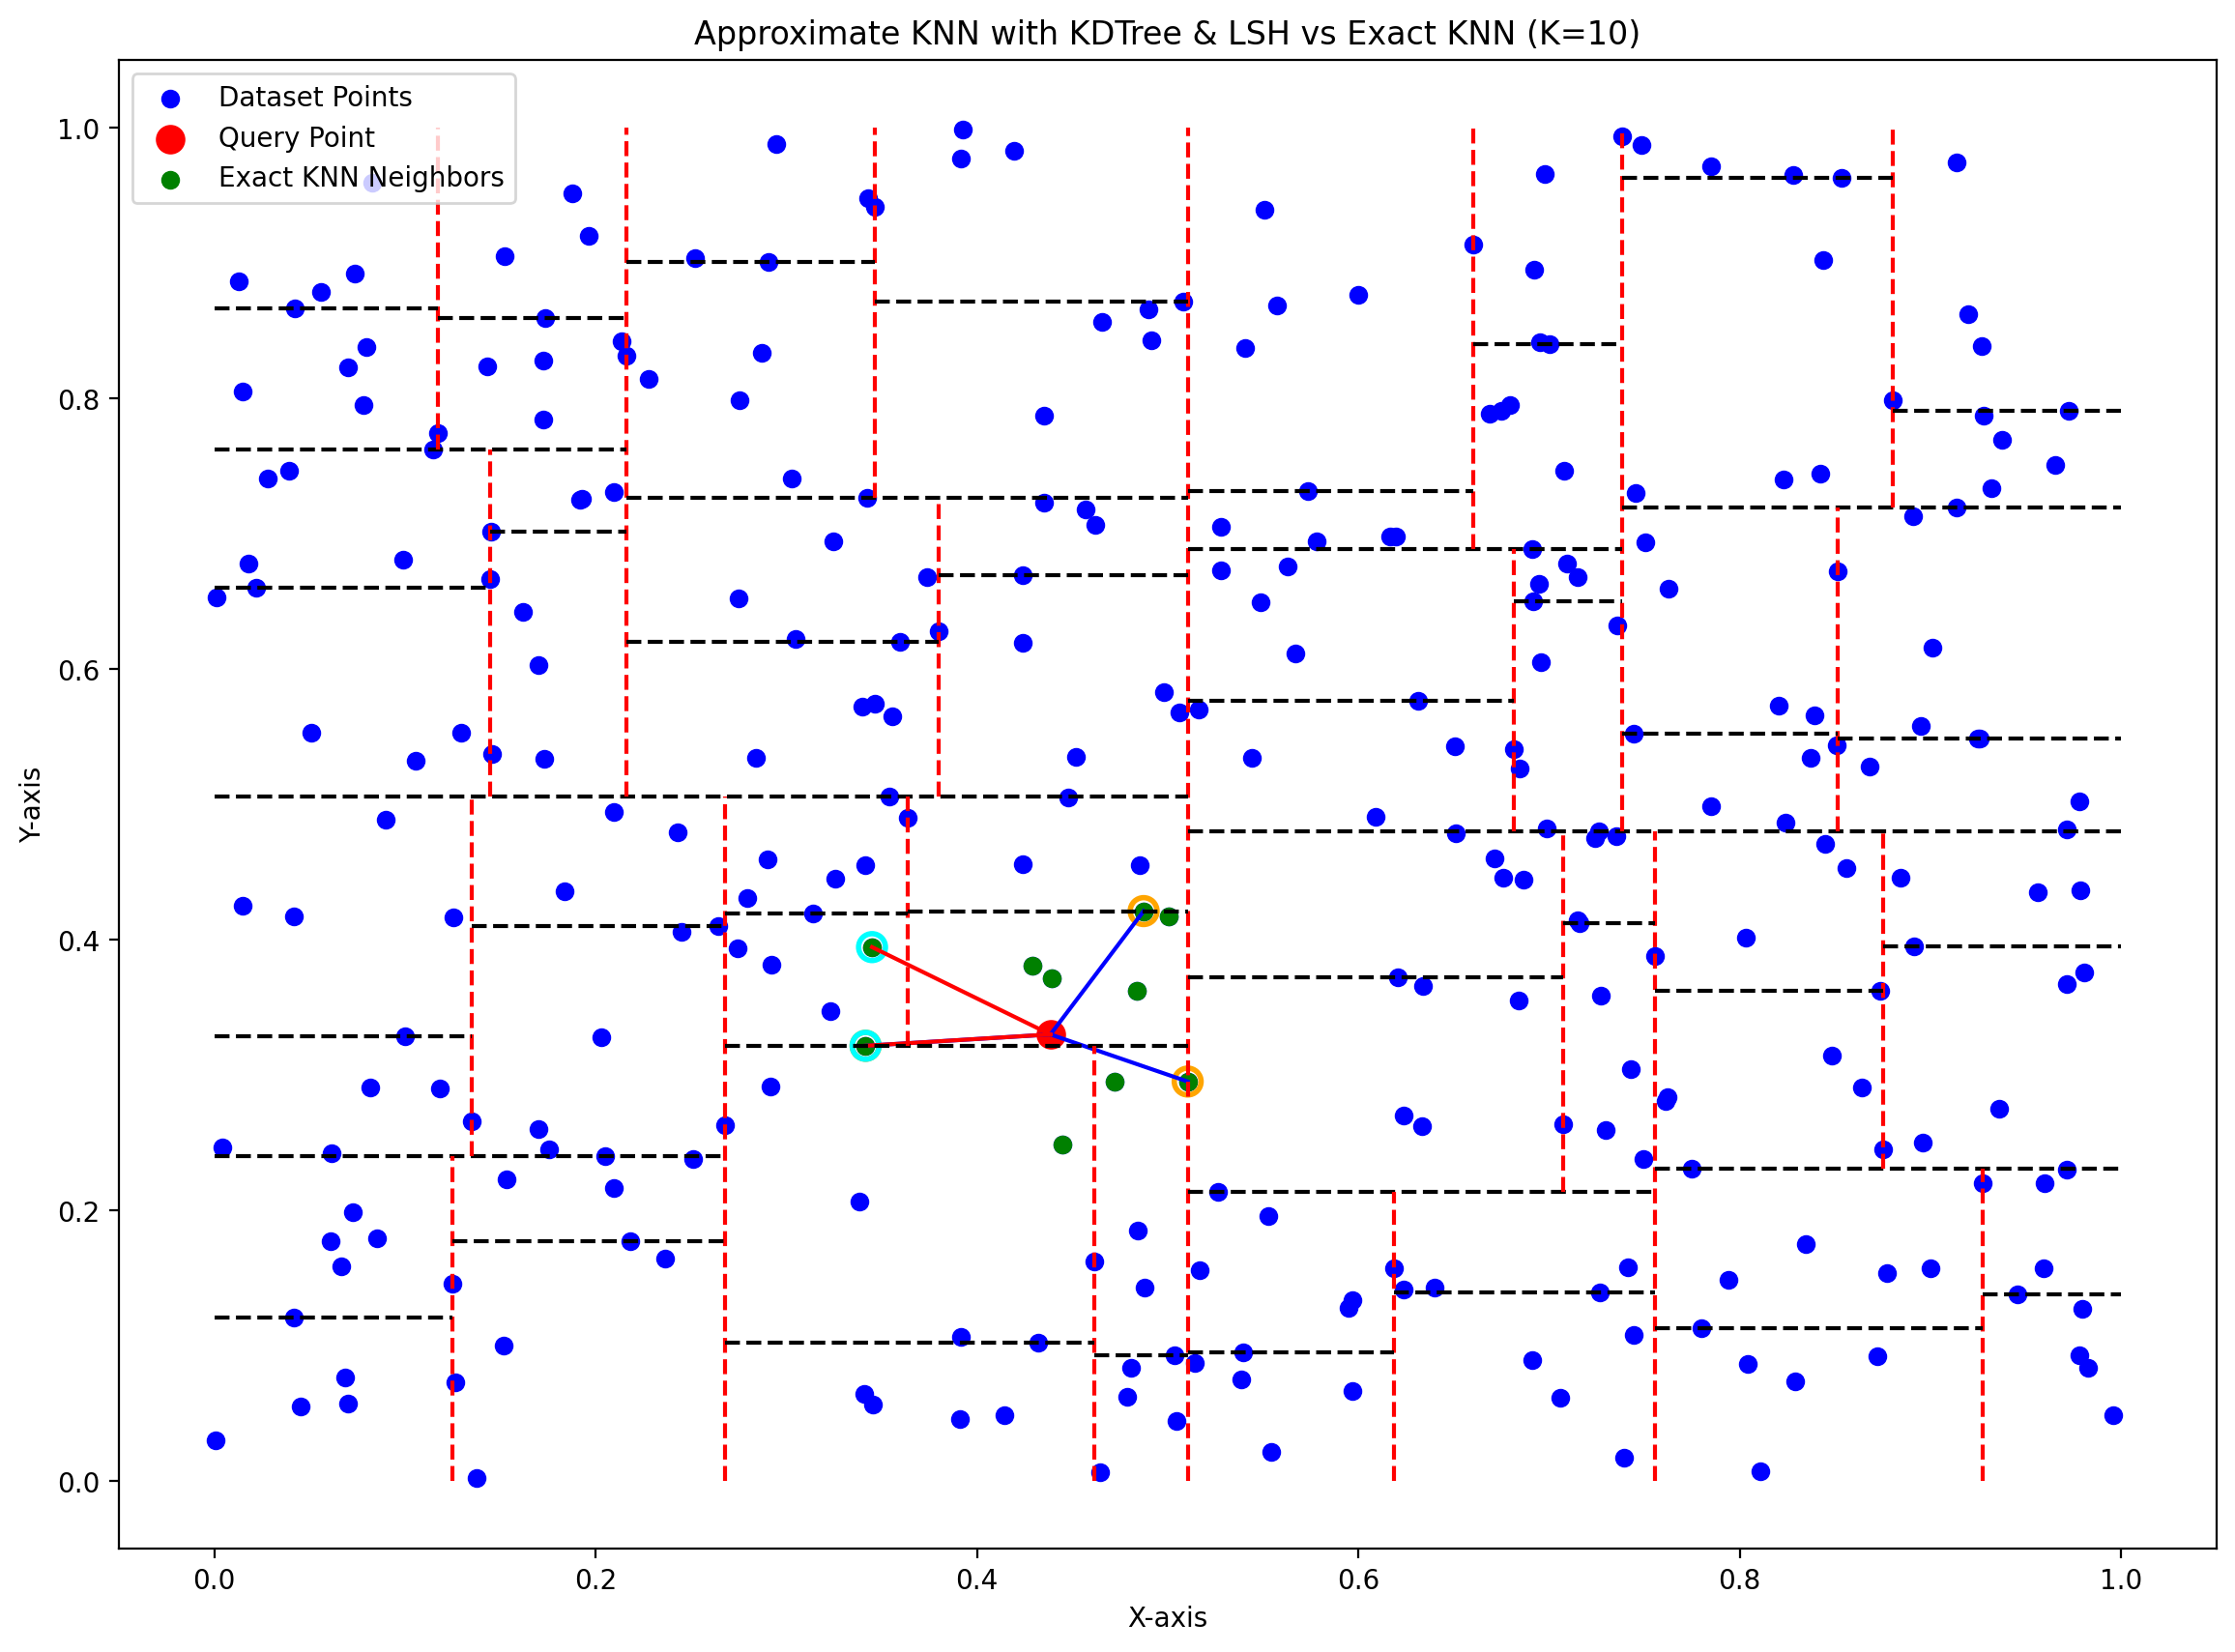

In [197]:
#generating a 2d dataset

N, D = 300, 2
ds = generate_dataset(N, D)

#value of k can be varied, we have taken it to be 5.

q = generate_query(D)

exact_indices, exact_points, distances_n = naive_knn(q, ds, K)

np.random.seed(4)


kdtree = KDTree(ds, leaf_size=5)
lsh = LSH(ds, num_hashes=num_hashes)

kd_indices, kd_points, kd_distances = kdtree.query(q, K)

lsh_indices, lsh_points, lsh_distances = lsh.query(q, K)

plt.figure(figsize=(14, 10))

plt.scatter(ds[:, 0], ds[:, 1], c='blue', label='Dataset Points')
plt.scatter(q[0], q[1], c='red', label='Query Point', marker='o', s=100)

plt.scatter(exact_points[:, 0], exact_points[:, 1], c='green', label='Exact KNN Neighbors')

missed_by_kdtree = []
for index in exact_indices:
    if index not in kd_indices:
        missed_by_kdtree.append(index)

for pt_1 in missed_by_kdtree:
    plt.plot([q[0], ds[pt_1, 0]], [q[1], ds[pt_1, 1]], 'b-')
    plt.scatter(ds[pt_1, 0], ds[pt_1, 1], edgecolor='orange', facecolor='none', s=100, linewidth=2)

missed_by_lsh = []
for index in exact_indices:
    if index not in lsh_indices:
        missed_by_lsh.append(index)

for pt_2 in missed_by_lsh:
    plt.plot([q[0], ds[pt_2, 0]], [q[1], ds[pt_2, 1]], 'r-')
    plt.scatter(ds[pt_2, 0], ds[pt_2, 1], edgecolor='cyan', facecolor='none', s=100, linewidth=2)

plot_kdtree_partitions(kdtree.tree)

plt.legend()
plt.title(f"Approximate KNN with KDTree & LSH vs Exact KNN (K={K})")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

Partitions

In [182]:
k = 5
N, D = 200, 2

ds = generate_dataset(N, D)
q = generate_query(D)

In [183]:
tree = KDTree(ds, leaf_size=5)
kd_indices, kd_points, lst = tree.query(q, K)

/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_25493/3632460437.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([median[0], median[0]], [ymin, ymax], 'k--', color = 'red')  # Vertical line
/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_25493/3632460437.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([xmin, xmax], [median[1], median[1]], 'k--', color = 'black')  # Horizontal line
/var/folders/55/_kpfspls6xq0pzzm_dl4ylxc0000gn/T/ipykernel_25493/3644717357.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


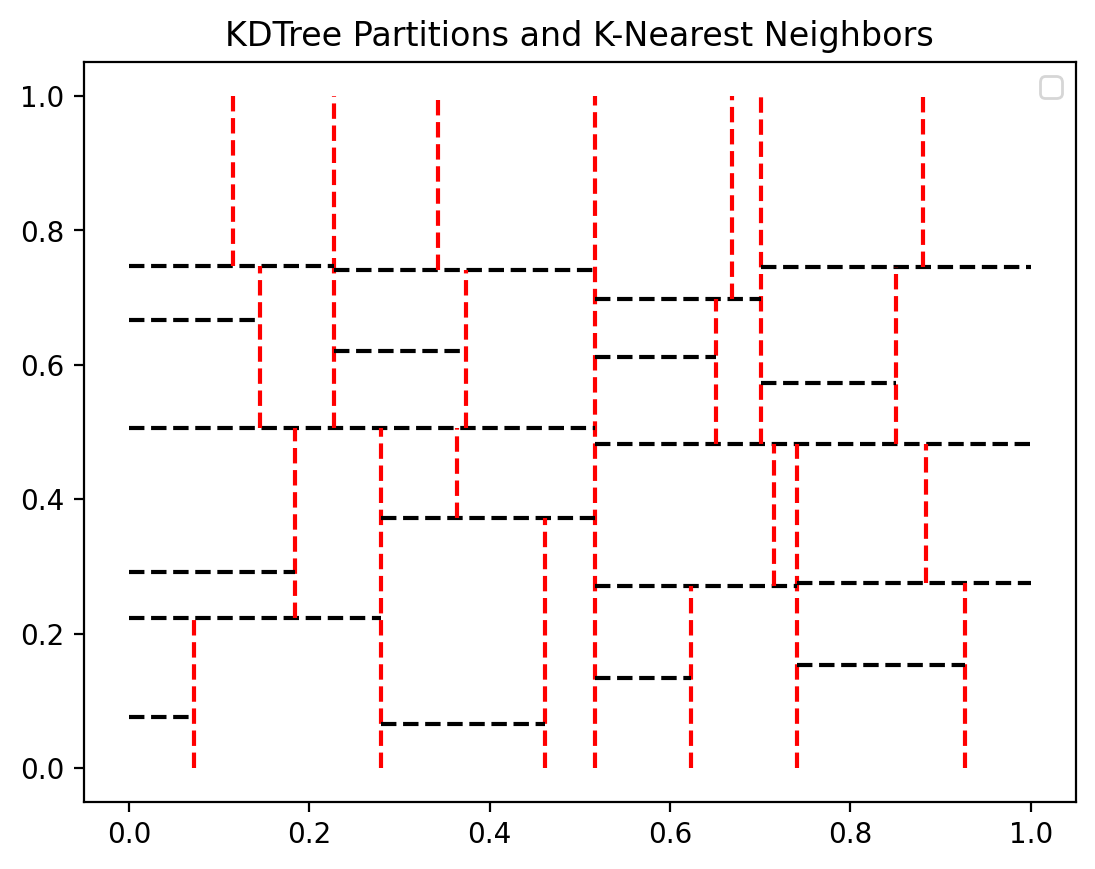

In [184]:

plot_kdtree_partitions(tree.tree)

# Show plot
plt.legend()
plt.title("KDTree Partitions and K-Nearest Neighbors")
plt.show()

Doing the same for LHS

In [193]:
def plot_partition_lsh(lsh):  
    np.random.seed(42)  
    for i in range(lsh.num_hashes):
        hash_plane = lsh.hashes[i]
        a, b, c = hash_plane[0], hash_plane[1], hash_plane[2]
        x_vals = np.linspace(lsh.dataset[:, 0].min(), lsh.dataset[:, 0].max(), 100)
        y_vals = (-a * x_vals - c) / b
        plt.plot(x_vals, y_vals, label=f'Hash function {i+1}')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Dataset Partitioning with Hyperplanes')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


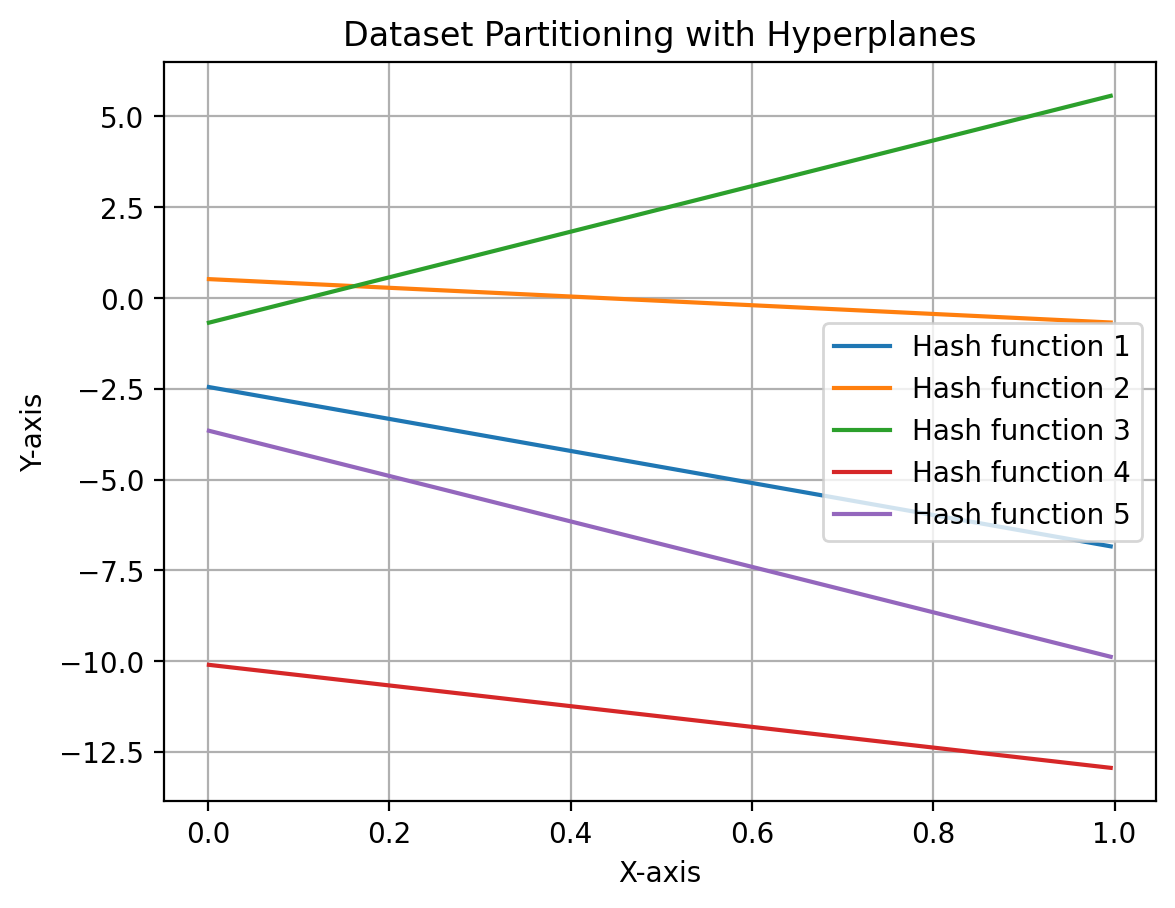

In [194]:
lsh = LSH(ds)
plot_partition_lsh(lsh)